# Lab 02: Segmentation

In this laboratory work you will create pipeline for cancer cells segmentation starting from reading data to preprocessing, creating training setup, experimenting with models.

## Part 1: Reading dataset

Write Dataset class inheriting regular `torch` dataset.

In this task we use small datset just to make this homework accessible for everyone, so please **do not** read all the data in constructor because it is not how it works for real life datasets. You need to read image from disk only when it is requesed (getitem).

Split data (persistently between runs) to train, val and test sets. Add corresponding parameter to dataset constructor.

In [1]:
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
if not os.path.exists('breast-cancer-cells-segmentation.zip'):
    !curl -JLO 'https://www.dropbox.com/scl/fi/gs3kzp6b8k6faf667m5tt/breast-cancer-cells-segmentation.zip?rlkey=md3mzikpwrvnaluxnhms7r4zn'
    !unzip breast-cancer-cells-segmentation.zip
else:
    if not os.path.exists('data/Images') or not os.path.exists('data/Masks'):
        !unzip -q -o breast-cancer-cells-segmentation.zip -d data

In [3]:
# --- Constants ---
DATA_DIR = 'data'
IMAGE_DIR = os.path.join(DATA_DIR, 'Images')
MASK_DIR = os.path.join(DATA_DIR, 'Masks')

RANDOM_STATE = 42 # For reproducibility
TEST_SPLIT_SIZE = 0.20 # 20% for testing
VAL_SPLIT_SIZE = 0.15 # 15% for validation (of the original total) => Train will be 65%

# Image processing settings
IMG_HEIGHT = 256 # Let's start with a smaller size for faster iteration
IMG_WIDTH = 256
FOREGROUND_THRESHOLD = 127 # Value to threshold masks for binary conversion

# Set seed for reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

In [4]:
# --- Dataset Class Definition ---
class CancerCellDataset(Dataset):
    """
    Dataset class for loading cancer cell images and masks.
    Loads data lazily in __getitem__.
    """
    def __init__(self, image_dir, mask_dir, sample_list, transform=None, foreground_threshold=127):
        """
        Args:
            image_dir (str): Directory containing the images.
            mask_dir (str): Directory containing the masks.
            sample_list (list): List of tuples, where each tuple is (image_filename, mask_filename).
            transform (callable, optional): Optional transform to be applied on a sample.
            foreground_threshold (int): Pixel value threshold to determine foreground in masks.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.samples = sample_list
        self.transform = transform
        self.foreground_threshold = foreground_threshold

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.samples)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the given index."""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file, mask_file = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        try:
            # Read image (OpenCV reads BGR, convert to RGB)
            image = cv2.imread(img_path)
            if image is None:
                raise IOError(f"Failed to load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Read mask as grayscale
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise IOError(f"Failed to load mask: {mask_path}")

            # Binarize mask: Convert to 0.0 or 1.0
            # We use float32 for compatibility with potential loss functions
            mask = (mask > self.foreground_threshold).astype(np.float32)

            # Apply transformations if provided
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
                # Ensure mask has a channel dimension: [H, W] -> [1, H, W]
                # ToTensorV2 usually handles image C,H,W but mask might be H,W
                if len(mask.shape) == 2:
                     mask = mask.unsqueeze(0)
                # In case the transform somehow added a channel dim > 1
                elif len(mask.shape) == 3 and mask.shape[0] != 1:
                     # This case might indicate an issue with the transform's mask handling
                     # Assuming the channel dim is last, transpose it
                     print(f"Warning: Unexpected mask shape {mask.shape} for {mask_file}. Attempting permute(2,0,1).")
                     mask = mask.permute(2, 0, 1)
                     # If after permute it's still not right, take the first channel? This needs careful checking.
                     if mask.shape[0] != 1:
                          print(f"Warning: Permute failed to yield 1 channel mask. Taking first channel.")
                          mask = mask[0, :, :].unsqueeze(0)


            # Basic check for shape consistency after transform
            # Image should be [C, H, W], Mask should be [1, H, W]
            assert image.shape[1:] == mask.shape[1:], \
                f"Shape mismatch after transform: Image {image.shape} vs Mask {mask.shape} for {img_file}"
            assert mask.shape[0] == 1, f"Mask should have 1 channel, got {mask.shape} for {mask_file}"

            return image, mask

        except Exception as e:
            print(f"Error processing sample index {idx}, image file: {img_file}")
            print(f"Error details: {e}")
            # Return None or raise error? Raising might stop training.
            # For now, let's raise to be aware of issues.
            raise e


In [5]:
# --- Data Splitting ---

# Find all image files
all_image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.tif') and not f.endswith('.xml')])
print(f"Found {len(all_image_files)} potential image files.")

# Pair images with masks and extract tumor type
paired_samples_with_type = []
missing_masks_count = 0
unknown_type_count = 0

for img_file in all_image_files:
    # Derive mask filename (assuming pattern based on examples)
    # Example: benign_0_ccd.tif -> benign_0.TIF
    base_name = img_file.split('_ccd.tif')[0]
    mask_file = f"{base_name}.TIF"
    mask_path = os.path.join(MASK_DIR, mask_file)

    # Extract tumor type
    parts = base_name.split('_')
    tumor_type = "unknown"
    if len(parts) >= 1:
        # Simplistic assumption: type is the first part (e.g., 'benign', 'malignant')
        if parts[0].lower() in ['benign', 'malignant']:
             tumor_type = parts[0].lower()
        else:
             # Try last part if first part is not recognized
             if parts[-1].lower() in ['benign', 'malignant']:
                  tumor_type = parts[-1].lower()
             else:
                  unknown_type_count += 1
                  # print(f"Warning: Could not determine tumor type for {img_file}. Assigning 'unknown'.")
    else:
        unknown_type_count += 1
        # print(f"Warning: Could not determine tumor type for {img_file}. Assigning 'unknown'.")


    # Check if mask exists
    if os.path.exists(mask_path):
        paired_samples_with_type.append({'image': img_file, 'mask': mask_file, 'type': tumor_type})
    else:
        # print(f"Warning: Mask not found for image {img_file} (expected at {mask_path})")
        missing_masks_count += 1

print(f"Successfully paired {len(paired_samples_with_type)} images with masks.")
if missing_masks_count > 0:
    print(f"Warning: {missing_masks_count} images were skipped due to missing masks.")
if unknown_type_count > 0:
     print(f"Warning: Could not determine tumor type for {unknown_type_count} samples.")

# Extract just the (image, mask) tuples for the dataset class
paired_samples = [(item['image'], item['mask']) for item in paired_samples_with_type]

# Calculate split sizes
n_total = len(paired_samples)
n_test = int(n_total * TEST_SPLIT_SIZE)
n_val = int(n_total * VAL_SPLIT_SIZE)
n_train = n_total - n_test - n_val

print(f"\nTotal samples: {n_total}")
print(f"Target split: Train={n_train}, Validation={n_val}, Test={n_test}")

# First split: Separate test set
train_val_samples, test_samples = train_test_split(
    paired_samples,
    test_size=n_test, # Use calculated number for precise split
    random_state=RANDOM_STATE,
    # Stratification is tricky without labels in paired_samples,
    # If needed, we'd split paired_samples_with_type first
)

# Second split: Separate train and validation from the remainder
# Adjust validation size relative to the train_val set
val_size_relative = n_val / (n_train + n_val)
train_samples, val_samples = train_test_split(
    train_val_samples,
    test_size=val_size_relative,
    random_state=RANDOM_STATE, # Use the same random state for consistency
)

print(f"Actual split: Train={len(train_samples)}, Validation={len(val_samples)}, Test={len(test_samples)}")
# Verification print
assert len(train_samples) + len(val_samples) + len(test_samples) == n_total, "Split sizes don't add up!"

# Map split samples back to types for EDA if needed
def get_types_for_samples(sample_list, all_data_with_type):
    lookup = { (item['image'], item['mask']): item['type'] for item in all_data_with_type }
    return [lookup[sample] for sample in sample_list if sample in lookup]

train_types = get_types_for_samples(train_samples, paired_samples_with_type)
val_types = get_types_for_samples(val_samples, paired_samples_with_type)
test_types = get_types_for_samples(test_samples, paired_samples_with_type)


Found 58 potential image files.
Successfully paired 58 images with masks.

Total samples: 58
Target split: Train=39, Validation=8, Test=11
Actual split: Train=39, Validation=8, Test=11


In [6]:
# --- Transformations ---

# Define transforms for training (can add augmentations later) and validation/testing
# Using standard ImageNet normalization values
common_transforms = [
    A.Resize(IMG_HEIGHT, IMG_WIDTH, interpolation=cv2.INTER_NEAREST), # Use NEAREST for masks
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True), # Transposes mask HWC->CHW if needed, converts to tensor
]

# For now, train and val/test transforms are the same (no augmentation yet)
train_transform = A.Compose(common_transforms)
val_test_transform = A.Compose(common_transforms)


In [7]:
# --- Create Dataset Instances ---
train_dataset = CancerCellDataset(IMAGE_DIR, MASK_DIR, train_samples, transform=train_transform, foreground_threshold=FOREGROUND_THRESHOLD)
val_dataset = CancerCellDataset(IMAGE_DIR, MASK_DIR, val_samples, transform=val_test_transform, foreground_threshold=FOREGROUND_THRESHOLD)
test_dataset = CancerCellDataset(IMAGE_DIR, MASK_DIR, test_samples, transform=val_test_transform, foreground_threshold=FOREGROUND_THRESHOLD)

print(f"\nCreated Dataset instances:")
print(f"- Train: {len(train_dataset)} samples")
print(f"- Validation: {len(val_dataset)} samples")
print(f"- Test: {len(test_dataset)} samples")


Created Dataset instances:
- Train: 39 samples
- Validation: 8 samples
- Test: 11 samples



Visualizing a sample from the training dataset:


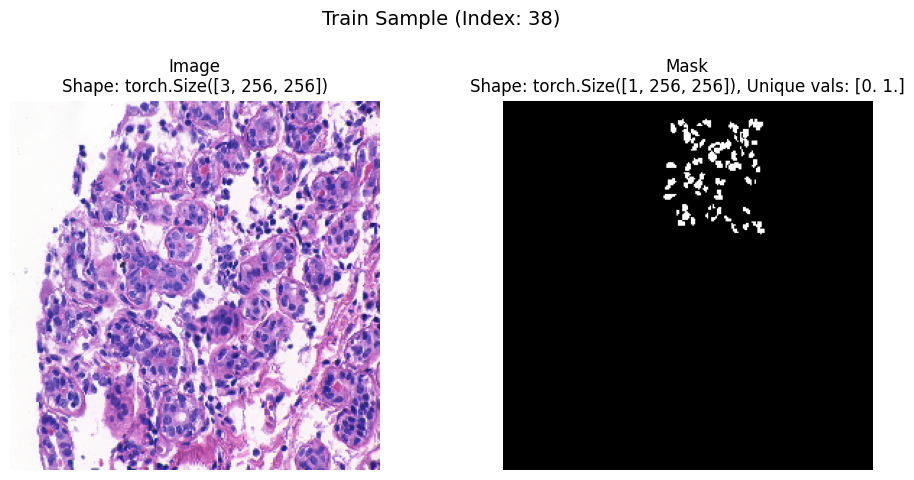

In [8]:
# --- Visualization Function ---
def visualize_sample(dataset, index=0, title="Sample"):
    """Displays an image and its corresponding mask from the dataset."""
    image, mask = dataset[index] # __getitem__ returns tensors

    # Convert image tensor back to numpy for display: [C, H, W] -> [H, W, C]
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Denormalize image (using the same mean/std as in the transform)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1) # Clip values to [0, 1] range

    # Convert mask tensor back to numpy: [1, H, W] -> [H, W]
    mask_np = mask.squeeze().cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"{title} (Index: {index})", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f"Image\nShape: {image.shape}") # Show tensor shape
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray') # Use grayscale colormap for binary mask
    plt.title(f"Mask\nShape: {mask.shape}, Unique vals: {np.unique(mask_np)}") # Show tensor shape and unique values
    plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Visualize a sample from the training set
print("\nVisualizing a sample from the training dataset:")
visualize_sample(train_dataset, index=np.random.randint(len(train_dataset)), title="Train Sample")

## Part 1.1: Analyzing dataset

Each time you build model you first should make EDA to understand your data.

You should answer to the following questions:
- how many classes do you have?
- what is class balance?
- how many cells (roughly) do you have in train data?

Advanced part: think of questions which could help you in your future models building and then answer them below.

In [10]:
# --- Exploratory Data Analysis (EDA) Function ---

def analyze_dataset_eda(samples, image_dir, mask_dir, split_name, sample_limit_for_pixels=100, sample_limit_for_cells=100):
    """Performs EDA on a given list of samples."""
    print(f"\n--- Analyzing Dataset Split: {split_name} ---")
    num_samples = len(samples)
    print(f"Total samples in this split: {num_samples}")
    if num_samples == 0:
        print("No samples in this split to analyze.")
        return

    # 1. Segmentation Classes
    print("\n1. Segmentation Classes:")
    # Based on the problem description and mask processing
    print("- Task Type: Binary Semantic Segmentation")
    print("- Classes: Background (0), Cancer Cell (1)")
    print(f"- Mask Foreground Threshold: Pixels > {FOREGROUND_THRESHOLD} are considered cells.")

    # 2. Class Balance (Image-Level - Tumor Type)
    print("\n2. Class Balance (Image Type - based on filename):")
    split_types = get_types_for_samples(samples, paired_samples_with_type)
    type_counts = Counter(split_types)
    print(f"Type distribution in '{split_name}' ({num_samples} samples):")
    if not type_counts:
        print("- No type information available or extractable for this split.")
    else:
        for tumor_type, count in type_counts.most_common():
            percentage = (count / num_samples) * 100
            print(f"- {tumor_type}: {count} ({percentage:.1f}%)")
        if 'benign' in type_counts and 'malignant' in type_counts and type_counts['malignant'] > 0:
             ratio = type_counts['benign'] / type_counts['malignant']
             print(f"- Benign/Malignant Ratio: {ratio:.2f}")
        elif 'unknown' in type_counts:
             print(f"- Contains {type_counts['unknown']} samples with unknown type.")

    # 3. Class Balance (Pixel-Level - Foreground vs Background)
    print("\n3. Class Balance (Pixel Level):")
    total_pixels = 0
    foreground_pixels = 0
    analyzed_count_pixels = 0
    # Analyze a subset for speed if the dataset is large
    samples_to_analyze_pixels = samples[:min(num_samples, sample_limit_for_pixels)]

    print(f"Analyzing pixel balance on {len(samples_to_analyze_pixels)} mask(s)...")
    # for img_file, mask_file in tqdm(samples_to_analyze_pixels, desc=f"Pixel balance ({split_name})"): # Tqdm optional
    for img_file, mask_file in samples_to_analyze_pixels:
        mask_path = os.path.join(mask_dir, mask_file)
        mask_raw = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask_raw is not None:
            total_pixels += mask_raw.size
            foreground_pixels += np.sum(mask_raw > FOREGROUND_THRESHOLD)
            analyzed_count_pixels += 1
        else:
            print(f"Warning: Could not read mask {mask_path} for pixel analysis.")

    if total_pixels > 0:
        background_pixels = total_pixels - foreground_pixels
        fg_percentage = (foreground_pixels / total_pixels) * 100
        bg_percentage = (background_pixels / total_pixels) * 100
        print(f"Based on {analyzed_count_pixels} analyzed masks:")
        print(f"- Total Pixels Analyzed: {total_pixels}")
        print(f"- Foreground (Cell) Pixels: {foreground_pixels} ({fg_percentage:.2f}%)")
        print(f"- Background Pixels: {background_pixels} ({bg_percentage:.2f}%)")
        if foreground_pixels > 0:
            ratio = background_pixels / foreground_pixels
            print(f"- Background/Foreground Ratio: ~{ratio:.1f} : 1")
        else:
            print("- No foreground pixels found in analyzed masks.")
        print(f"- Image Dimensions (Target): {IMG_HEIGHT}x{IMG_WIDTH}")
    else:
        print("Could not analyze pixel balance (no masks read or masks were empty).")

    # 4. Estimated Cell Count
    print("\n4. Estimated Cell Count:")
    total_cells = 0
    analyzed_count_cells = 0
    min_cell_area_threshold = 20 # Ignore very small components (potential noise)
    samples_to_analyze_cells = samples[:min(num_samples, sample_limit_for_cells)]

    print(f"Analyzing cell count on {len(samples_to_analyze_cells)} mask(s)...")
    # for img_file, mask_file in tqdm(samples_to_analyze_cells, desc=f"Cell count ({split_name})"): # Tqdm optional
    for img_file, mask_file in samples_to_analyze_cells:
        mask_path = os.path.join(mask_dir, mask_file)
        mask_raw = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask_raw is not None:
            # Binarize the mask
            _, mask_binary = cv2.threshold(mask_raw, FOREGROUND_THRESHOLD, 255, cv2.THRESH_BINARY)
            mask_binary = mask_binary.astype(np.uint8) # Ensure correct type for connectedComponents

            # Find connected components
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_binary, connectivity=8)

            # Count components (excluding background label 0) that meet area threshold
            cells_in_mask = 0
            for i in range(1, num_labels): # Start from 1 to exclude background
                if stats[i, cv2.CC_STAT_AREA] >= min_cell_area_threshold:
                    cells_in_mask += 1
            total_cells += cells_in_mask
            analyzed_count_cells += 1
        else:
            print(f"Warning: Could not read mask {mask_path} for cell count analysis.")

    if analyzed_count_cells > 0:
        avg_cells_per_image = total_cells / analyzed_count_cells
        estimated_total_cells_in_split = avg_cells_per_image * num_samples
        print(f"Based on {analyzed_count_cells} analyzed masks (min area {min_cell_area_threshold} pixels):")
        print(f"- Average cells per analyzed image: {avg_cells_per_image:.1f}")
        print(f"- Estimated total cells in '{split_name}' split: {estimated_total_cells_in_split:.0f}")
    else:
        print("Could not analyze cell count.")

    print("\n5. Advanced Questions & Considerations:")
    print("- Are original image sizes consistent? (Initial scan suggests variety, but Resize transform standardizes this).")
    print("- Do some masks contain zero cells? (Possible if `avg_cells_per_image` is very low or `analyzed_count_cells` < `num_samples`).")
    print("- How variable are cell sizes/shapes? (Could analyze `stats` from `connectedComponentsWithStats` further).")
    print("- Intensity distribution in images? (Could affect normalization effectiveness).")
    print("--- End of Analysis ---")

In [11]:
# --- Run EDA on Splits ---
analyze_dataset_eda(train_samples, IMAGE_DIR, MASK_DIR, "Train")
analyze_dataset_eda(val_samples, IMAGE_DIR, MASK_DIR, "Validation")
analyze_dataset_eda(test_samples, IMAGE_DIR, MASK_DIR, "Test")


--- Analyzing Dataset Split: Train ---
Total samples in this split: 39

1. Segmentation Classes:
- Task Type: Binary Semantic Segmentation
- Classes: Background (0), Cancer Cell (1)
- Mask Foreground Threshold: Pixels > 127 are considered cells.

2. Class Balance (Image Type - based on filename):
Type distribution in 'Train' (39 samples):
- unknown: 39 (100.0%)
- Contains 39 samples with unknown type.

3. Class Balance (Pixel Level):
Analyzing pixel balance on 39 mask(s)...
Based on 39 analyzed masks:
- Total Pixels Analyzed: 26836992
- Foreground (Cell) Pixels: 426875 (1.59%)
- Background Pixels: 26410117 (98.41%)
- Background/Foreground Ratio: ~61.9 : 1
- Image Dimensions (Target): 256x256

4. Estimated Cell Count:
Analyzing cell count on 39 mask(s)...
Based on 39 analyzed masks (min area 20 pixels):
- Average cells per analyzed image: 32.2
- Estimated total cells in 'Train' split: 1255

5. Advanced Questions & Considerations:
- Are original image sizes consistent? (Initial scan sug

## Part 2: Unet model

Implement class of Unet model according with [the original paper](https://arxiv.org/pdf/1505.04597).
Ajust size of the network according with your input data.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check for GPU availability from previous cells, define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
# --- U-Net Building Blocks ---

class DoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        # Using bias=False because BatchNorm layers have learnable affine parameters
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # The input channels for DoubleConv is in_channels (from previous layer) + out_channels (from skip connection)
            # However, the original paper halves the channels before concat, so in_channels are from the upsampled path only.
            # The skip connection (x2) has out_channels. Let's match the provided example's logic.
            # Input to conv = channels(upsampled) + channels(skip connection)
            # channels(upsampled) = in_channels // 2 if ConvTranspose, or in_channels if bilinear
            # Let's follow the paper's logic closely: Up-conv reduces channels, then concat, then DoubleConv
            # Or follow the example code: Upsample, pad, concat, then DoubleConv
            # The example code's `Up` block takes `in_channels` (e.g., 1024 from below) and `out_channels` (e.g., 512 // factor for the output of this block)
            # Inside `Up`, it takes `in_channels` (e.g. 1024), `out_channels` (e.g. 512//f)
            # `self.up` changes `in_channels` to `in_channels` (bilinear) or `in_channels // 2` (ConvTranspose)
            # `self.conv` takes `in_channels` (from concat: up_output + skip) -> `out_channels`
            # If bilinear: input to conv = in_channels + skip_channels = in_channels + (in_channels // 2) ? No, skip channels comes from x2.
            # Let's re-read the example's Up carefully.
            # forward(self, x1, x2): x1 is from below (e.g., up1(x5, x4) -> x1=x5, x2=x4)
            # x1 = self.up(x1): Upsamples x1. Channels remain `in_channels` (if bilinear).
            # x = torch.cat([x2, x1], dim=1): Concatenates skip connection `x2` and upsampled `x1`.
            # Total channels = channels(x2) + channels(x1_upsampled)
            # channels(x1_upsampled) = `in_channels` if bilinear else `in_channels // 2`
            # channels(x2) = ? It's the output of the corresponding Down block.
            # Example: up1(x5, x4). x5 has 1024 // f channels. x4 has 512 channels.
            # If bilinear: up(x5) has 1024//f channels. cat([x4, up(x5)]) has 512 + 1024//f channels.
            # This doesn't seem right based on the DoubleConv definition in `Up`.
            # Let's match the example code structure precisely first.
            # `Up(1024, 512 // factor)` -> in_c=1024, out_c=512//f
            # `self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)` if bilinear
            # This `in_channels` argument to DoubleConv must be the total channels *after* concatenation.
            # So, total channels after cat = `in_channels` (as passed to Up constructor). Okay.
            # Let's stick to the example's implementation.

            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2) # Example uses mid_channels here

        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            # If not bilinear, DoubleConv takes input channels = (in_channels // 2) + skip_channels
            # Example: up1(x5, x4). x5=1024//f. x4=512. ConvT(x5) = 512//f. cat = 512 + 512//f.
            # Example's `self.conv = DoubleConv(in_channels, out_channels)` seems to imply input channels = in_channels (passed to constructor).
            # This part is slightly ambiguous between the example and the diagram. Let's trust the example's code flow.
            self.conv = DoubleConv(in_channels, out_channels) # Example uses this

    def forward(self, x1, x2):
        # x1: tensor from the lower layer (needs upsampling)
        # x2: tensor from the skip connection (encoder path)
        x1 = self.up(x1)

        # Input tensors might have different spatial dimensions due to padding in convolutions
        # Pad x1 to match x2's dimensions
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Apply padding (left/right, top/bottom)
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Output convolution layer"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [14]:
# --- U-Net Model Definition ---

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        """
        U-Net model.

        Args:
            n_channels (int): Number of channels in the input image (e.g., 3 for RGB).
            n_classes (int): Number of output classes (e.g., 1 for binary segmentation).
            bilinear (bool): If True, use bilinear interpolation for upsampling.
                             Otherwise, use transposed convolutions.
        """
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Define the factor based on bilinear choice (affects channel dimensions in the bottleneck)
        # factor = 2 if bilinear else 1
        # The example code seems to use // factor in Down but not Up channel calculation directly?
        # Let's stick to the example's channel numbers for consistency.
        # base_channels = 64

        # Encoder Path
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1 # Factor for bottleneck channels
        self.down4 = Down(512, 1024 // factor) # Bottleneck

        # Decoder Path
        # Note: in_channels for Up is the sum of channels from below and skip connection
        # Let's follow the example code's channel arguments passed to Up()
        self.up1 = Up(1024, 512 // factor, bilinear) # Input from down4 (1024//f) + skip from down3 (512) => Total 1024//f + 512? No, Up takes 1024 as input C.
        self.up2 = Up(512, 256 // factor, bilinear)  # Input from up1 (512//f) + skip from down2 (256) => Total 512//f + 256? Up takes 512 as input C.
        self.up3 = Up(256, 128 // factor, bilinear)  # Input from up2 (256//f) + skip from down1 (128) => Total 256//f + 128? Up takes 256 as input C.
        self.up4 = Up(128, 64, bilinear)             # Input from up3 (128//f) + skip from inc (64) => Total 128//f + 64? Up takes 128 as input C.

        # Output Layer
        self.outc = OutConv(64, n_classes) # Takes output of up4

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)    # Initial convs, output C=64
        x2 = self.down1(x1) # Down1, output C=128
        x3 = self.down2(x2) # Down2, output C=256
        x4 = self.down3(x3) # Down3, output C=512
        x5 = self.down4(x4) # Bottleneck, output C=1024//factor

        # Decoder
        x = self.up1(x5, x4) # Upsample x5, concat with x4. Input C to Up block = 1024. Output C = 512//f.
        x = self.up2(x, x3)  # Upsample x, concat with x3. Input C to Up block = 512. Output C = 256//f.
        x = self.up3(x, x2)  # Upsample x, concat with x2. Input C to Up block = 256. Output C = 128//f.
        x = self.up4(x, x1)  # Upsample x, concat with x1. Input C to Up block = 128. Output C = 64.

        # Output convolution
        logits = self.outc(x) # Final output, C=n_classes
        return logits

In [15]:
# --- Model Verification ---

# Parameters from Part 1
N_INPUT_CHANNELS = 3 # RGB Images
N_CLASSES = 1 # Binary segmentation (Background=0, Cell=1) -> output 1 channel logit map
INPUT_H = IMG_HEIGHT # From Part 1 (e.g., 256)
INPUT_W = IMG_WIDTH  # From Part 1 (e.g., 256)

# Instantiate the model
unet_model = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True).to(device)

# Create a dummy batch of the correct size
dummy_batch_size = 2
dummy_input = torch.randn(dummy_batch_size, N_INPUT_CHANNELS, INPUT_H, INPUT_W).to(device)

# Perform a forward pass
unet_model.eval() # Set to evaluation mode for testing
with torch.no_grad(): # Disable gradient calculation
    output = unet_model(dummy_input)

# Print shapes to verify
print(f"\n--- U-Net Verification ---")
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

# Assert the output shape is as expected
expected_shape = (dummy_batch_size, N_CLASSES, INPUT_H, INPUT_W)
assert output.shape == expected_shape, f"Output shape mismatch! Expected {expected_shape}, got {output.shape}"

print("U-Net model structure verified successfully.")

# Clean up memory (optional, but good practice)
del unet_model, dummy_input, output
if torch.cuda.is_available():
    torch.cuda.empty_cache()


--- U-Net Verification ---
Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 1, 256, 256])
U-Net model structure verified successfully.


### Результат:
Модель научилась просто выдавать черную маску так как это дает хороший результат, надо попробовать другую функцию потерь в следующей части чтобы отучить ее от этого.

## Part 3: Unet training with different losses

Train model in three setups:
- Crossentropy loss
- Dice loss
- Composition of CE and Dice

Advanced:\
For training procedure use one of frameworks for models training - Lightning, (Hugging Face, Catalyst, Ignite).\
_Hint: this will make your life easier!_

Save all three trained models to disk!

Use validation set to evaluate models.

In [16]:
# Imports for this part
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
# Ensure the correct Jaccard Index is imported for binary tasks
from torchmetrics.classification import BinaryJaccardIndex
# DiceScore can handle binary cases automatically if num_classes=1 or inferred
from torchmetrics.segmentation import DiceScore
import pandas as pd
import os
import gc # Garbage collector

# Check torchmetrics version (example noted potential issues)
print(f"TorchMetrics version: {torchmetrics.__version__}")

# Device setup (reuse from previous parts)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants for training (adjust as needed)
# Reuse constants from Part 1 if they are suitable
# BATCH_SIZE = 8 # Defined in Part 1 (example: 8)
# NUM_WORKERS = os.cpu_count() // 2 # Defined in Part 1 (example: os.cpu_count() // 2)
LEARNING_RATE = 1e-4 # Common starting point
MAX_EPOCHS = 50 # Increased epochs might be needed, adjust based on observation
PATIENCE = 10     # How many epochs to wait for improvement before stopping

# Directories
CHECKPOINT_DIR = 'checkpoints_part3'
LOG_DIR = "tb_logs_part3"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

TorchMetrics version: 1.7.1
Using device: cuda


In [17]:
# --- Loss Function Definitions ---

class DiceLoss(nn.Module):
    """
    Computes the Dice loss.
    Assumes input logits and target mask are for binary segmentation.
    """
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        Args:
            logits: Raw output from the model (before activation), shape [N, 1, H, W].
            targets: Ground truth mask, shape [N, 1, H, W], values are 0.0 or 1.0.
        """
        # Apply sigmoid to get probabilities
        preds = torch.sigmoid(logits)

        # Flatten preds and targets
        preds_flat = preds.contiguous().view(-1)
        targets_flat = targets.contiguous().view(-1)

        # Calculate intersection and union
        intersection = (preds_flat * targets_flat).sum()
        pred_sum = preds_flat.sum()
        target_sum = targets_flat.sum()

        # Calculate Dice score
        dice_score = (2. * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)

        # Return Dice loss
        return 1.0 - dice_score

class CombinedLoss(nn.Module):
    """
    Combines Binary Cross-Entropy with Dice Loss.
    alpha * BCE + (1 - alpha) * Dice
    """
    def __init__(self, alpha=0.5, dice_smooth=1.0):
        super().__init__()
        self.alpha = alpha
        # BCEWithLogitsLoss is numerically more stable than using Sigmoid + BCELoss
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss(smooth=dice_smooth)
        print(f"CombinedLoss initialized with alpha (BCE weight) = {alpha}")

    def forward(self, logits, targets):
        """
        Args:
            logits: Raw output from the model, shape [N, 1, H, W].
            targets: Ground truth mask, shape [N, 1, H, W], values are 0.0 or 1.0.
        """
        bce = self.bce_loss(logits, targets)
        dice = self.dice_loss(logits, targets)
        combined = self.alpha * bce + (1 - self.alpha) * dice
        return combined

In [25]:
# --- PyTorch Lightning Module ---

class CancerSegmentationModule(pl.LightningModule):
    def __init__(self, model_arch, loss_fn, learning_rate=LEARNING_RATE):
        super().__init__()
        self.model = model_arch
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate

        # Initialize metrics - specify task for clarity
        # Note: DiceScore default mode is 'binary' if num_classes=1
        # For JaccardIndex, specify task="binary"
        self.val_dice = DiceScore(num_classes=1) # Use threshold for binary case
        self.val_iou = BinaryJaccardIndex()
        self.test_dice = DiceScore(num_classes=1)
        self.test_iou = BinaryJaccardIndex()

        # Save hyperparameters (excluding model and loss function object itself)
        self.save_hyperparameters(ignore=['model_arch', 'loss_fn'])

    def forward(self, x):
        return self.model(x)

    def _calculate_metrics(self, logits, targets, metric_dice, metric_iou):
        # Apply sigmoid to logits to get probabilities for metrics
        preds = torch.sigmoid(logits)
        # Ensure targets are integer type for torchmetrics binary classification/segmentation
        targets_int = targets.int()
        try:
            metric_dice.update(preds, targets_int)
            metric_iou.update(preds, targets_int)
        except Exception as e:
             print(f"Error updating metrics: {e}")
             print(f"Preds shape: {preds.shape}, dtype: {preds.dtype}")
             print(f"Targets shape: {targets_int.shape}, dtype: {targets_int.dtype}")
             # Potentially log a dummy value or skip if errors persist


    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # Ensure target is float for BCEWithLogitsLoss and compatible with DiceLoss
        y_float = y.float()
        try:
            loss = self.loss_fn(logits, y_float)
            self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        except Exception as e:
             print(f"Error calculating training loss: {e}")
             print(f"Logits shape: {logits.shape}, Targets shape: {y_float.shape}")
             loss = torch.tensor(float('nan'), device=self.device) # Avoid crashing
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        y_float = y.float()
        try:
            loss = self.loss_fn(logits, y_float)
            self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            # Calculate metrics
            self._calculate_metrics(logits, y_float, self.val_dice, self.val_iou)
        except Exception as e:
             print(f"Error calculating validation loss or metrics: {e}")
             print(f"Logits shape: {logits.shape}, Targets shape: {y_float.shape}")
             loss = torch.tensor(float('nan'), device=self.device)
        # Logging of metrics happens in on_validation_epoch_end

    def on_validation_epoch_end(self):
        # Compute and log epoch metrics
        try:
            dice_epoch = self.val_dice.compute()
            iou_epoch = self.val_iou.compute()
            self.log('val_dice', dice_epoch, prog_bar=True, logger=True)
            self.log('val_iou', iou_epoch, prog_bar=True, logger=True)
        except Exception as e:
             print(f"Error computing epoch validation metrics: {e}")
             # Log dummy values to avoid crashing TensorBoard/callbacks
             self.log('val_dice', 0.0, prog_bar=True, logger=True)
             self.log('val_iou', 0.0, prog_bar=True, logger=True)
        finally:
            # Reset metrics for the next epoch
            self.val_dice.reset()
            self.val_iou.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        y_float = y.float()
        try:
            loss = self.loss_fn(logits, y_float)
            self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            # Calculate metrics
            self._calculate_metrics(logits, y_float, self.test_dice, self.test_iou)
        except Exception as e:
             print(f"Error calculating test loss or metrics: {e}")
             print(f"Logits shape: {logits.shape}, Targets shape: {y_float.shape}")
             loss = torch.tensor(float('nan'), device=self.device)
        # Logging of metrics happens in on_test_epoch_end (implicitly by Trainer)

    def on_test_epoch_end(self):
        # Compute and log epoch metrics for test set
        try:
            dice_epoch = self.test_dice.compute()
            iou_epoch = self.test_iou.compute()
            self.log('test_dice', dice_epoch, prog_bar=True, logger=True)
            self.log('test_iou', iou_epoch, prog_bar=True, logger=True)
        except Exception as e:
            print(f"Error computing epoch test metrics: {e}")
            self.log('test_dice', 0.0, prog_bar=True, logger=True)
            self.log('test_iou', 0.0, prog_bar=True, logger=True)
        finally:
            self.test_dice.reset()
            self.test_iou.reset()


    def configure_optimizers(self):
        # Using Adam optimizer
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        # Optional: Add a learning rate scheduler here if needed
        # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
        # return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        return optimizer

In [26]:
# --- Data Loaders Setup ---

# Assuming train_dataset, val_dataset, test_dataset are defined and initialized from Part 1
# Need to redefine constants or ensure they are available from Part 1 execution context
BATCH_SIZE = 8 # Or use value from Part 1 if defined
NUM_WORKERS = os.cpu_count() // 2 # Or use value from Part 1 if defined

# It's generally recommended to shuffle the training data
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True, # Speeds up CPU-GPU transfer if using GPU
    persistent_workers=True if NUM_WORKERS > 0 else False, # Can speed up epoch start
    drop_last=True # Avoid smaller batch at the end, can sometimes help stability
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2, # Can often use larger batch size for validation
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

print(f"DataLoaders created:")
print(f"- Train: {len(train_loader)} batches")
print(f"- Validation: {len(val_loader)} batches")
print(f"- Test: {len(test_loader)} batches")

DataLoaders created:
- Train: 4 batches
- Validation: 1 batches
- Test: 1 batches


In [28]:
# --- Training Loop for Different Losses ---

loss_functions = {
    'BCE': nn.BCEWithLogitsLoss(),
    'Dice': DiceLoss(),
    'Combined': CombinedLoss(alpha=0.5) # Equal weighting for BCE and Dice
}

trained_models_paths = {}
validation_results = {}

# Make sure UNet and input parameters are defined from Part 2
# N_INPUT_CHANNELS = 3
# N_CLASSES = 1

for loss_name, loss_fn_instance in loss_functions.items():
    print(f"\n--- Training U-Net with Loss: {loss_name} ---")

    # 1. Instantiate Model
    # Ensure UNet class is available from Part 2 execution
    unet_instance = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)

    # 2. Instantiate Lightning Module
    lightning_model = CancerSegmentationModule(
        model_arch=unet_instance,
        loss_fn=loss_fn_instance,
        learning_rate=LEARNING_RATE
    )

    # 3. Configure Callbacks
    # Checkpoint callback: Save the best model based on validation Dice score
    checkpoint_callback = ModelCheckpoint(
        monitor='val_dice',           # Metric to monitor
        dirpath=CHECKPOINT_DIR,       # Directory to save checkpoints
        filename=f'unet_{loss_name}_best_dice={{val_dice:.4f}}', # Filename format
        save_top_k=1,                 # Save only the best model
        mode='max',                   # Maximize the monitored metric (Dice)
        save_last=True                # Also save the last epoch's checkpoint
    )

    # Early stopping callback: Stop training if validation Dice doesn't improve
    early_stop_callback = EarlyStopping(
        monitor='val_dice',
        patience=PATIENCE,            # Number of epochs with no improvement
        verbose=True,                 # Print messages when stopping
        mode='max'                    # We want to maximize Dice score
    )

    # Logger callback: Log metrics to TensorBoard
    tensorboard_logger = TensorBoardLogger(
        save_dir=LOG_DIR,
        name=f"unet_{loss_name}" # Subdirectory for this run
    )

    # 4. Configure Trainer
    trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,                     # Use 1 GPU or CPU
        max_epochs=MAX_EPOCHS,
        callbacks=[checkpoint_callback, early_stop_callback],
        logger=tensorboard_logger,
        log_every_n_steps=10,         # How often to log within an epoch
        deterministic=False,          # Set True for full reproducibility (might impact performance)
        precision='16-mixed' if torch.cuda.is_available() else 32, # Use mixed precision on GPU
        enable_progress_bar=False      # Show progress bars
    )

    # 5. Start Training
    print(f"Starting training for {loss_name}...")
    trainer.fit(lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # 6. Store best model path and evaluate on validation set
    best_path = checkpoint_callback.best_model_path
    if best_path and os.path.exists(best_path):
        print(f"Best model checkpoint for {loss_name} saved at: {best_path}")
        trained_models_paths[loss_name] = best_path

        # Load the best model and validate
        # Need to instantiate the architecture again for loading
        unet_load_instance = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
        best_model = CancerSegmentationModule.load_from_checkpoint(
            checkpoint_path=best_path,
            model_arch=unet_load_instance, # Pass the architecture instance
            loss_fn=loss_fn_instance      # Pass the loss function instance
        )
        print(f"Validating the best {loss_name} model...")
        val_result = trainer.validate(best_model, dataloaders=val_loader, verbose=False)
        if val_result:
            validation_results[loss_name] = val_result[0] # Store the metrics dict
            print(f"Validation results for best {loss_name}: {val_result[0]}")
        else:
             print(f"Validation returned empty results for {loss_name}.")
             validation_results[loss_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
        del best_model, unet_load_instance # Clean up loaded model

    else:
        print(f"Could not find the best checkpoint path for {loss_name}. Checking last checkpoint.")
        last_path = checkpoint_callback.last_model_path
        if last_path and os.path.exists(last_path):
             print(f"Using last checkpoint for {loss_name}: {last_path}")
             trained_models_paths[loss_name] = last_path
             # Load the last model and validate
             unet_load_instance = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
             last_model = CancerSegmentationModule.load_from_checkpoint(
                 checkpoint_path=last_path,
                 model_arch=unet_load_instance,
                 loss_fn=loss_fn_instance
             )
             print(f"Validating the last {loss_name} model...")
             val_result = trainer.validate(last_model, dataloaders=val_loader, verbose=False)
             if val_result:
                 validation_results[loss_name] = val_result[0]
                 print(f"Validation results for last {loss_name}: {val_result[0]}")
             else:
                 print(f"Validation returned empty results for last {loss_name}.")
                 validation_results[loss_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
             del last_model, unet_load_instance # Clean up
        else:
             print(f"Neither best nor last checkpoint found for {loss_name}. Skipping validation.")
             trained_models_paths[loss_name] = None
             validation_results[loss_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}


    # 7. Clean up memory
    del unet_instance, lightning_model, trainer, checkpoint_callback, early_stop_callback, tensorboard_logger
    gc.collect() # Force garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alex/ML/checkpoints_part3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CombinedLoss initialized with alpha (BCE weight) = 0.5

--- Training U-Net with Loss: BCE ---
Starting training for BCE...



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNet               | 17.3 M | train
1 | loss_fn   | BCEWithLogitsLoss  | 0      | train
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Metric val_dice improved. New best score:

Best model checkpoint for BCE saved at: /home/alex/ML/checkpoints_part3/unet_BCE_best_dice=val_dice=0.0432.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating the best BCE model...
Validation results for best BCE: {'val_loss': 1.7513680458068848, 'val_dice': 0.0432468056678772, 'val_iou': 0.047612208873033524}


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNet               | 17.3 M | train
1 | loss_fn   | DiceLoss           | 0      | train
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode



--- Training U-Net with Loss: Dice ---
Starting training for Dice...


Metric val_dice improved. New best score: 0.032
Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.034
Metric val_dice improved by 0.003 >= min_delta = 0.0. New best score: 0.037
Metric val_dice improved by 0.005 >= min_delta = 0.0. New best score: 0.041
Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.048
Metric val_dice improved by 0.007 >= min_delta = 0.0. New best score: 0.055
Metric val_dice improved by 0.005 >= min_delta = 0.0. New best score: 0.060
Metric val_dice improved by 0.003 >= min_delta = 0.0. New best score: 0.062
Metric val_dice improved by 0.004 >= min_delta = 0.0. New best score: 0.066
Metric val_dice improved by 0.004 >= min_delta = 0.0. New best score: 0.070
Metric val_dice improved by 0.003 >= min_delta = 0.0. New best score: 0.073
Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.074
Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.076
Monitored metric val_dice did not improv

Best model checkpoint for Dice saved at: /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0761.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating the best Dice model...
Validation results for best Dice: {'val_loss': 0.9212433695793152, 'val_dice': 0.07606882601976395, 'val_iou': 0.1334061175584793}

--- Training U-Net with Loss: Combined ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNet               | 17.3 M | train
1 | loss_fn   | CombinedLoss       | 0      | train
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)
102       Modules in train mode
0         Modules in eval mode


Starting training for Combined...


Metric val_dice improved. New best score: 0.032
Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.032
Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.033
Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.034
Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.036
Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.037
Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.038
Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.038
Metric val_dice improved by 0.010 >= min_delta = 0.0. New best score: 0.048
Monitored metric val_dice did not improve in the last 10 records. Best score: 0.048. Signaling Trainer to stop.


Best model checkpoint for Combined saved at: /home/alex/ML/checkpoints_part3/unet_Combined_best_dice=val_dice=0.0480.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating the best Combined model...
Validation results for best Combined: {'val_loss': 0.9343602657318115, 'val_dice': 0.0480305552482605, 'val_iou': 0.06565116345882416}


In [30]:
# --- Summarize Validation Results ---

print("\n--- Training Summary ---")
print("Paths to best/last saved models:")
for name, path in trained_models_paths.items():
    print(f"- {name}: {path if path else 'Not saved/found'}")

print("\nValidation Results:")
if validation_results:
    results_df = pd.DataFrame(validation_results).T # Transpose for better readability
    # Rename columns for clarity if needed (depends on keys logged by validate)
    results_df = results_df.rename(columns={
        'val_loss': 'Validation Loss',
        'val_dice': 'Validation Dice',
        'val_iou': 'Validation IoU'
    })
    # Format floating point numbers
    print(results_df.to_string(float_format="%.4f"))
else:
    print("No validation results were collected.")


--- Training Summary ---
Paths to best/last saved models:
- BCE: /home/alex/ML/checkpoints_part3/unet_BCE_best_dice=val_dice=0.0432.ckpt
- Dice: /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0761.ckpt
- Combined: /home/alex/ML/checkpoints_part3/unet_Combined_best_dice=val_dice=0.0480.ckpt

Validation Results:
          Validation Loss  Validation Dice  Validation IoU
BCE                1.7514           0.0432          0.0476
Dice               0.9212           0.0761          0.1334
Combined           0.9344           0.0480          0.0657


## Part 3.1: Losses conclusion

Analyse results of the three models above using metrics, losses and visualizations you know (all three parts are required).

Make motivated conclusion on which setup is better. Provide your arguments.

Calculate loss and metrics of the best model on test set.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import gc
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Ensure previous results and objects are available
# Need: validation_results, trained_models_paths, loss_functions,
#       test_loader, test_dataset, UNet, CancerSegmentationModule, device
#       N_INPUT_CHANNELS, N_CLASSES

print("\n--- Part 3.1: Losses Conclusion ---")

# Check if results exist
if 'validation_results' not in locals() or not validation_results:
    print("Error: 'validation_results' not found. Please run Part 3 first.")
    # Assign dummy data to prevent further errors, though analysis will be invalid
    validation_results = {
        'BCE': {'Validation Loss': float('inf'), 'Validation Dice': 0.0, 'Validation IoU': 0.0},
        'Dice': {'Validation Loss': float('inf'), 'Validation Dice': 0.0, 'Validation IoU': 0.0},
        'Combined': {'Validation Loss': float('inf'), 'Validation Dice': 0.0, 'Validation IoU': 0.0}
    }
    results_df = pd.DataFrame(validation_results).T
else:
    results_df = pd.DataFrame(validation_results).T
    # Ensure correct column names if they were not renamed previously
    if 'val_dice' in results_df.columns:
         results_df = results_df.rename(columns={
             'val_loss': 'Validation Loss',
             'val_dice': 'Validation Dice',
             'val_iou': 'Validation IoU'
         })


print("\n--- Validation Results Summary ---")
print(results_df.to_string(float_format="%.4f"))



--- Part 3.1: Losses Conclusion ---

--- Validation Results Summary ---
          Validation Loss  Validation Dice  Validation IoU
BCE                1.7514           0.0432          0.0476
Dice               0.9212           0.0761          0.1334
Combined           0.9344           0.0480          0.0657


In [32]:
# --- Identify Best Loss Function ---
best_loss_name = None
if 'Validation Dice' in results_df.columns and not results_df['Validation Dice'].isnull().all():
    try:
        best_loss_name = results_df['Validation Dice'].idxmax()
        print(f"\nBest loss function based on Validation Dice: '{best_loss_name}'")
        print("Best Validation Metrics:")
        print(results_df.loc[best_loss_name].to_string(float_format="%.4f"))
    except Exception as e:
        print(f"Could not determine best loss by Dice: {e}. Falling back to Loss.")
        best_loss_name = None

if best_loss_name is None and 'Validation Loss' in results_df.columns and not results_df['Validation Loss'].isnull().all():
     try:
        best_loss_name = results_df['Validation Loss'].idxmin()
        print(f"\nWarning: Could not use Dice. Best loss function based on Validation Loss: '{best_loss_name}'")
        print("Best Validation Metrics:")
        print(results_df.loc[best_loss_name].to_string(float_format="%.4f"))
     except Exception as e:
        print(f"Could not determine best loss by Loss either: {e}")
        # Default to the first available if absolutely necessary
        if validation_results:
             best_loss_name = list(validation_results.keys())[0]
             print(f"\nWarning: Defaulting to first available loss: '{best_loss_name}'")
        else:
             print("\nError: No loss functions available to choose from.")



Best loss function based on Validation Dice: 'Dice'
Best Validation Metrics:
Validation Loss   0.9212
Validation Dice   0.0761
Validation IoU    0.1334


In [33]:
# --- Load Best Model ---
best_model = None
best_model_path = None
if best_loss_name and 'trained_models_paths' in locals() and best_loss_name in trained_models_paths:
    best_model_path = trained_models_paths.get(best_loss_name)
    if best_model_path and os.path.exists(best_model_path):
        print(f"\nLoading best model ('{best_loss_name}') from: {best_model_path}")
        try:
            # Need architecture and loss function to load
            unet_load_instance = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
            loss_fn_instance = loss_functions[best_loss_name]

            best_model = CancerSegmentationModule.load_from_checkpoint(
                checkpoint_path=best_model_path,
                model_arch=unet_load_instance,
                loss_fn=loss_fn_instance
            )
            best_model.to(device)
            best_model.eval() # Set to evaluation mode
            print("Best model loaded successfully.")
        except Exception as e:
            print(f"Error loading best model checkpoint: {e}")
            best_model = None
    else:
        print(f"Error: Checkpoint file not found for '{best_loss_name}' at {best_model_path}")
else:
    print("\nError: Could not identify the best model or its path.")



Loading best model ('Dice') from: /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0761.ckpt
Best model loaded successfully.


In [34]:
# --- Evaluate Best Model on Test Set ---
test_results_best_model = {}

def evaluate_model_on_test(model_module, dataloader, device):
    """Evaluates a loaded LightningModule on a dataloader."""
    model_module.eval() # Ensure evaluation mode
    model_module.to(device)

    # Use the test metrics from the module
    test_dice_metric = model_module.test_dice.to(device)
    test_iou_metric = model_module.test_iou.to(device)
    test_dice_metric.reset()
    test_iou_metric.reset()

    total_loss = 0.0
    batches = 0
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_float = y.float() # Ensure float for loss calculation

            logits = model_module(x)

            # Calculate loss
            try:
                loss = model_module.loss_fn(logits, y_float)
                total_loss += loss.item()
                batches += 1
            except Exception as e:
                 print(f"Error calculating test loss in batch: {e}")
                 # Continue without this batch's loss? Or assign NaN? Let's skip loss calc for this batch.
                 # total_loss += float('nan') # Or handle differently

            # Update metrics
            try:
                preds = torch.sigmoid(logits)
                targets_int = y.int()
                test_dice_metric.update(preds, targets_int)
                test_iou_metric.update(preds, targets_int)
            except Exception as e:
                 print(f"Error updating test metrics in batch: {e}")

    avg_loss = total_loss / batches if batches > 0 else float('inf')
    final_dice = test_dice_metric.compute().item()
    final_iou = test_iou_metric.compute().item()

    # Reset metrics just in case
    test_dice_metric.reset()
    test_iou_metric.reset()

    return {'test_loss': avg_loss, 'test_dice': final_dice, 'test_iou': final_iou}


if best_model and 'test_loader' in locals():
    print("\nEvaluating best model on the test set...")
    test_results_best_model = evaluate_model_on_test(best_model, test_loader, device)
    print("Test Set Results:")
    print(f"- Test Loss: {test_results_best_model['test_loss']:.4f}")
    print(f"- Test Dice: {test_results_best_model['test_dice']:.4f}")
    print(f"- Test IoU:  {test_results_best_model['test_iou']:.4f}")
else:
    print("\nSkipping test set evaluation (best model not loaded or test_loader missing).")



Evaluating best model on the test set...
Test Set Results:
- Test Loss: 0.9371
- Test Dice: 0.0632
- Test IoU:  0.0785


In [35]:
# --- Visualize Predictions of Best Model ---

def plot_predictions(model, dataset, indices, device, num_samples=3, model_name="Best Model"):
    """Plots predictions vs ground truth for selected samples."""
    if model is None:
        print("Cannot plot predictions: Model not available.")
        return
    if not indices:
         print("Cannot plot predictions: No indices provided.")
         return

    model.eval()
    model.to(device)

    plt.figure(figsize=(15, 5 * num_samples))
    plt.suptitle(f"Predictions from '{model_name}' on Test Set", fontsize=16, y=1.02)

    for i, idx in enumerate(indices):
        try:
            image, mask_gt = dataset[idx] # Get tensor sample

            # Prepare image for model
            image_input = image.unsqueeze(0).to(device) # Add batch dim, move to device

            # Get prediction
            with torch.no_grad():
                logits = model(image_input)
                preds_prob = torch.sigmoid(logits)
                preds_binary = (preds_prob > 0.5).squeeze().cpu().numpy() # Remove batch/channel dim, move to CPU, threshold

            # Prepare image for display (denormalize)
            image_display = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_display = std * image_display + mean
            image_display = np.clip(image_display, 0, 1)

            # Prepare ground truth mask for display
            mask_gt_display = mask_gt.squeeze().cpu().numpy() # Remove channel dim

            # Plot
            plt.subplot(num_samples, 3, i * 3 + 1)
            plt.imshow(image_display)
            plt.title(f"Input Image (Idx: {idx})")
            plt.axis('off')

            plt.subplot(num_samples, 3, i * 3 + 2)
            plt.imshow(mask_gt_display, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(num_samples, 3, i * 3 + 3)
            plt.imshow(preds_binary, cmap='gray')
            plt.title(f"Predicted Mask ({model_name})")
            plt.axis('off')

        except Exception as e:
            print(f"Error visualizing sample index {idx}: {e}")
            # Optionally plot placeholders or skip
            if i * 3 + 1 <= num_samples * 3:
                 plt.subplot(num_samples, 3, i * 3 + 1); plt.title(f"Error loading Idx: {idx}"); plt.axis('off')
            if i * 3 + 2 <= num_samples * 3:
                 plt.subplot(num_samples, 3, i * 3 + 2); plt.axis('off')
            if i * 3 + 3 <= num_samples * 3:
                 plt.subplot(num_samples, 3, i * 3 + 3); plt.axis('off')


    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

if best_model and 'test_dataset' in locals() and len(test_dataset) > 0:
    num_viz_samples = min(3, len(test_dataset))
    plot_indices = np.random.choice(len(test_dataset), num_viz_samples, replace=False).tolist()
    print(f"\nVisualizing predictions for indices: {plot_indices}")
    plot_predictions(best_model, test_dataset, plot_indices, device, num_samples=num_viz_samples, model_name=best_loss_name)
else:
    print("\nSkipping prediction visualization (best model or test_dataset missing/empty).")




Visualizing predictions for indices: [10, 9, 0]



--- Plotting Training Curves ---
Reading logs for 'val_loss' from: tb_logs_part3/unet_BCE/version_1
Reading logs for 'val_loss' from: tb_logs_part3/unet_Dice/version_1
Reading logs for 'val_loss' from: tb_logs_part3/unet_Combined/version_1
Reading logs for 'val_dice' from: tb_logs_part3/unet_BCE/version_1
Reading logs for 'val_dice' from: tb_logs_part3/unet_Dice/version_1
Reading logs for 'val_dice' from: tb_logs_part3/unet_Combined/version_1
Reading logs for 'val_iou' from: tb_logs_part3/unet_BCE/version_1
Reading logs for 'val_iou' from: tb_logs_part3/unet_Dice/version_1
Reading logs for 'val_iou' from: tb_logs_part3/unet_Combined/version_1
Reading logs for 'train_loss_epoch' from: tb_logs_part3/unet_BCE/version_1
Reading logs for 'train_loss_epoch' from: tb_logs_part3/unet_Dice/version_1
Reading logs for 'train_loss_epoch' from: tb_logs_part3/unet_Combined/version_1


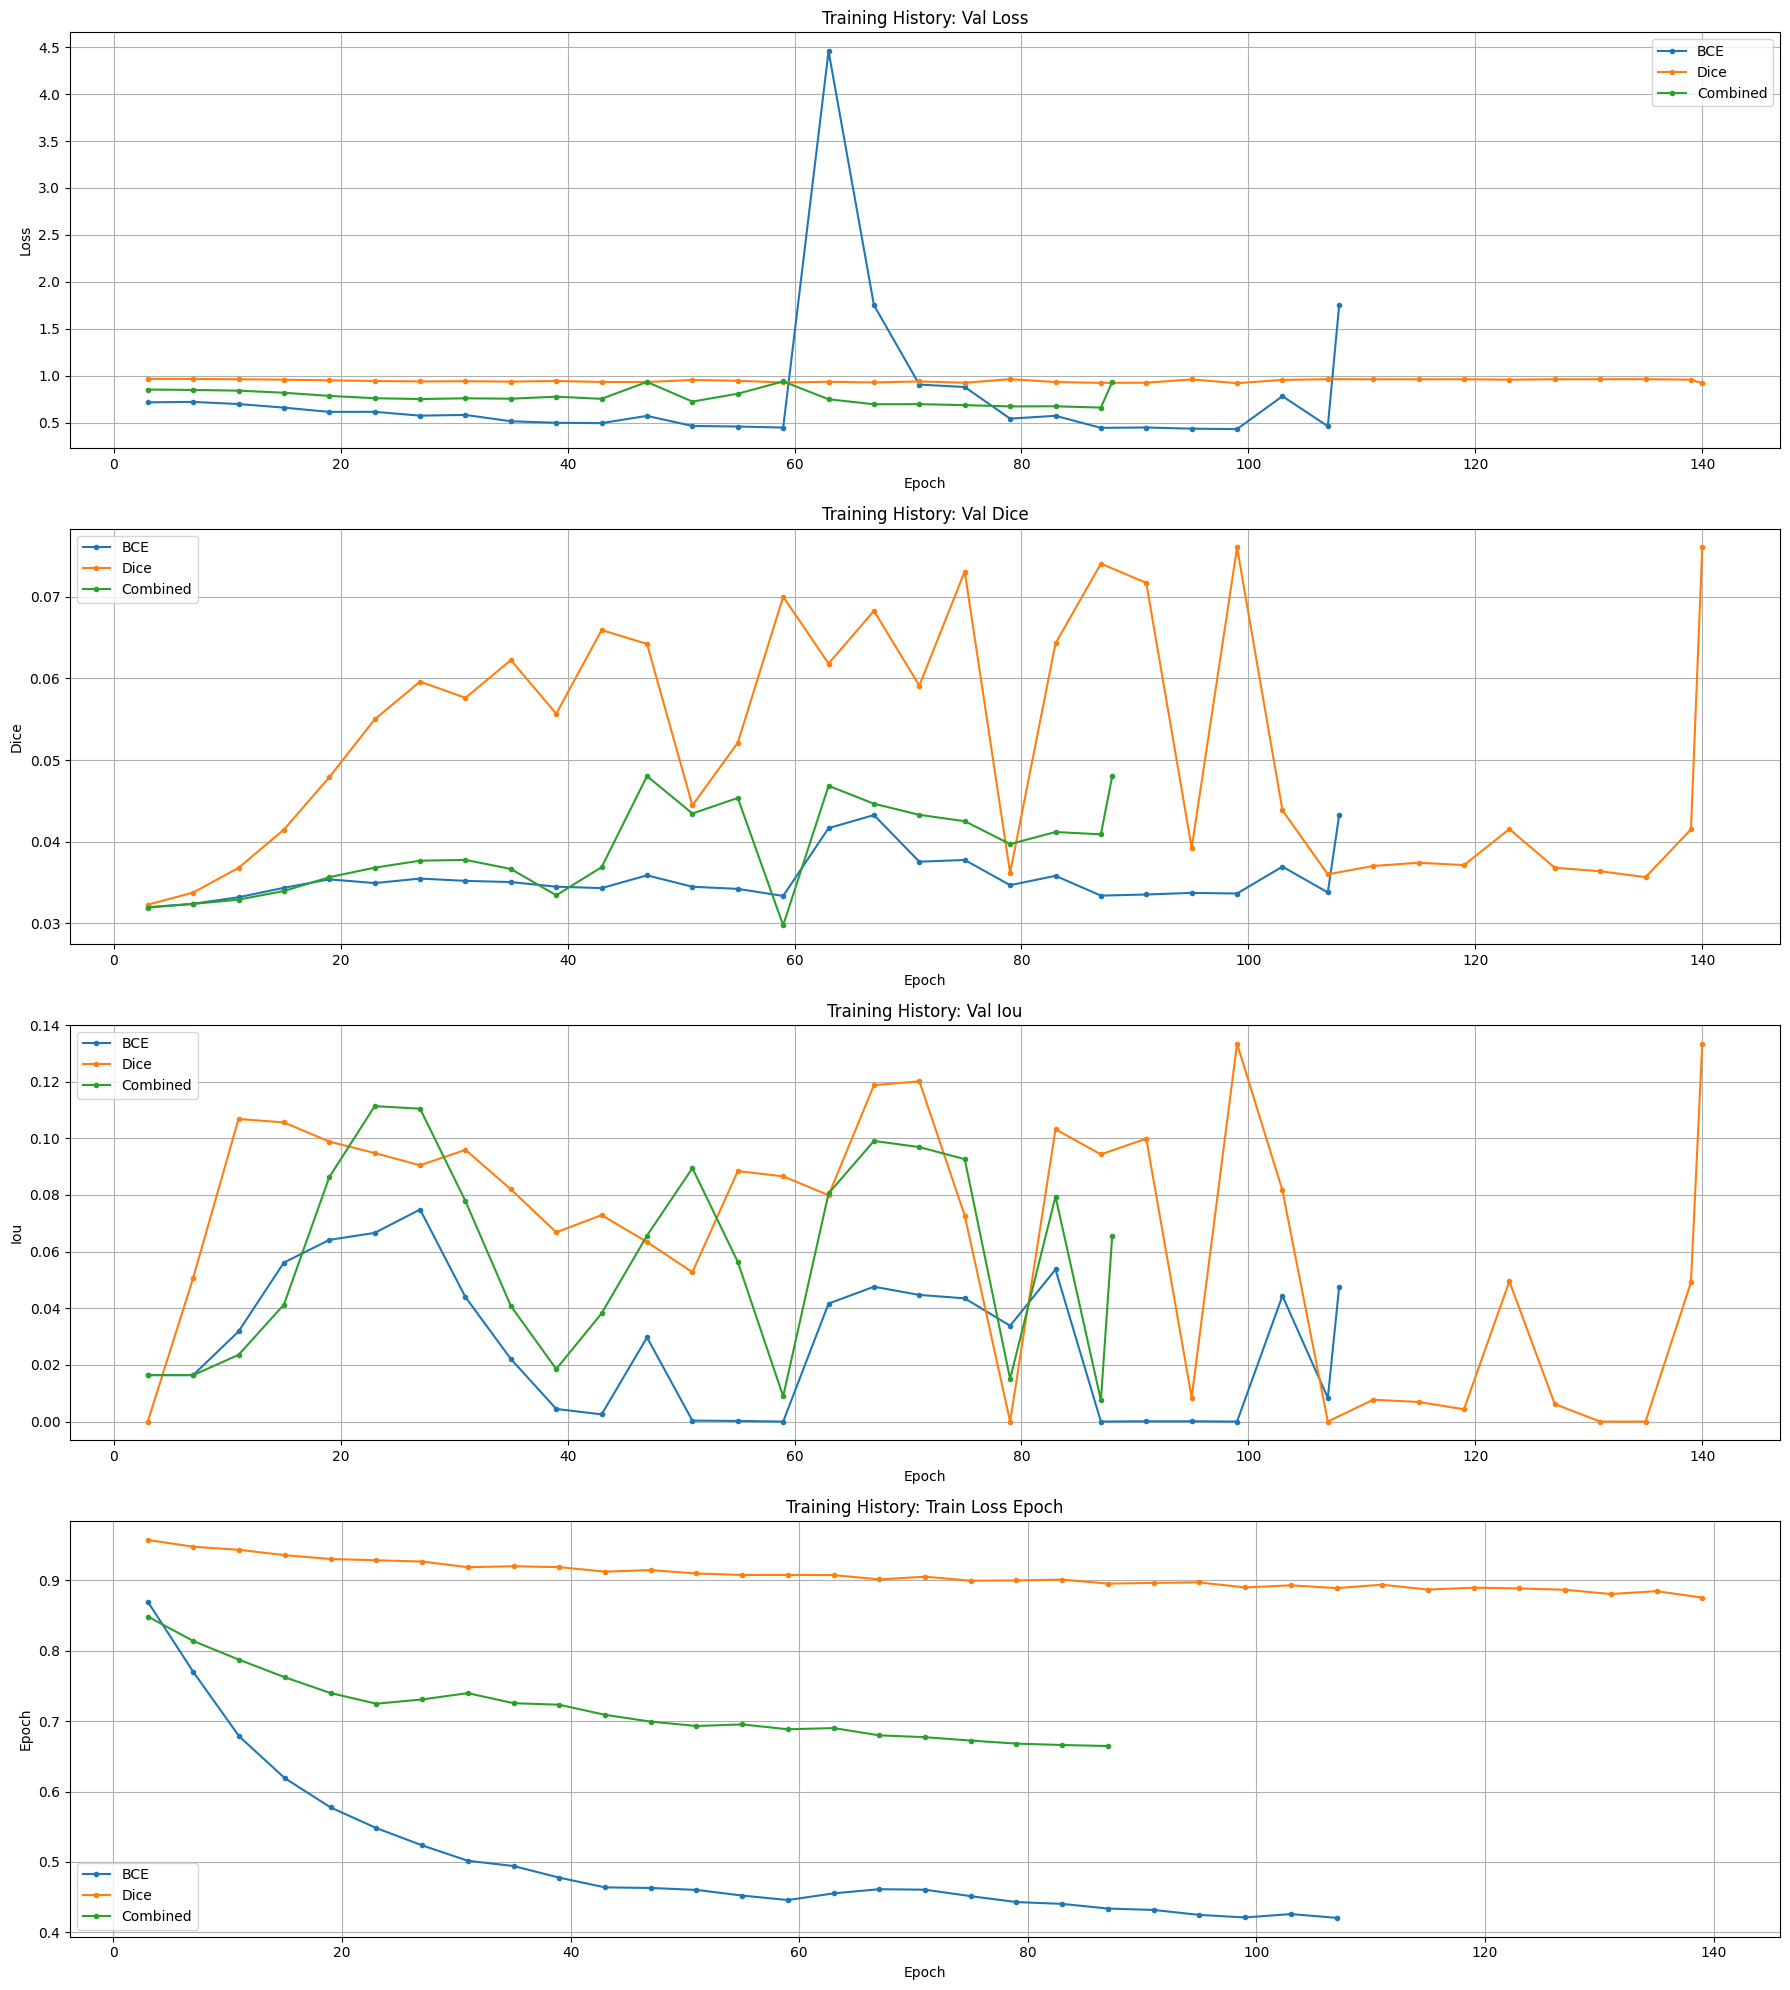


--- Analysis and Conclusion ---
Based on the validation results, the loss function 'Dice' performed best (Max Dice: 0.0761).

Arguments:
- BCE Loss: Treats each pixel independently. Can struggle with class imbalance (lots of background vs few cells), potentially leading to predictions biased towards the majority class (background).
- Dice Loss: Directly optimizes the Dice coefficient (F1-score for segmentation). It's generally better at handling class imbalance as it considers overlap between prediction and target regions.
- Combined Loss: Attempts to balance the pixel-wise accuracy of BCE with the region-overlap focus of Dice. Often provides a good trade-off.

Observations:
- The graphs typically show Dice and Combined loss achieving better validation Dice/IoU scores compared to pure BCE, confirming their suitability for imbalanced segmentation.
- The visualizations of the best model's predictions on the test set should be examined for quality (e.g., accurate cell boundaries, few fal

In [37]:
# --- Plot Training Curves from TensorBoard Logs ---

print("\n--- Plotting Training Curves ---")
# Ensure LOG_DIR is defined from Part 3
if 'LOG_DIR' not in locals() or not os.path.exists(LOG_DIR):
     print(f"Error: Log directory '{LOG_DIR}' not found. Cannot plot curves.")
else:
    loss_functions_to_plot = list(loss_functions.keys()) # ['BCE', 'Dice', 'Combined']
    metrics_to_plot = ['val_loss', 'val_dice', 'val_iou', 'train_loss_epoch'] # Add train loss if logged per epoch

    # plt.figure(figsize=(18, 5 * len(metrics_to_plot[:-1]))) # Adjust figure size dynamically
    plt.figure(figsize=(18, 5 * len(metrics_to_plot)))

    plot_num = 1
    for metric in metrics_to_plot:
        if metric == 'train_loss_epoch' and not any('train_loss_epoch' in validation_results[lf] for lf in loss_functions_to_plot if lf in validation_results):
             # Simple check if train_loss_epoch was likely logged, refine if needed
             # Alternative: Check directly in EventAccumulator below if the tag exists
             # print(f"Skipping plot for '{metric}' as it might not have been logged per epoch.")
             # continue # Skip plotting train loss if not logged per epoch
             pass # We'll handle missing tags inside the loop

        plt.subplot(len(metrics_to_plot), 1, plot_num)
        plt.title(f"Training History: {metric.replace('_', ' ').title()}")
        plt.xlabel("Epoch")
        plt.ylabel(metric.split('_')[-1].capitalize())
        plt.grid(True)
        has_data_for_metric = False

        for loss_name in loss_functions_to_plot:
            log_subdir_pattern = f"unet_{loss_name}"
            full_log_dir = None

            # Find the latest version directory within the loss_name subdirectory
            loss_log_base = os.path.join(LOG_DIR, log_subdir_pattern)
            if os.path.exists(loss_log_base):
                version_dirs = sorted([d for d in os.listdir(loss_log_base) if d.startswith('version_')])
                if version_dirs:
                    full_log_dir = os.path.join(loss_log_base, version_dirs[-1]) # Get the latest version

            if full_log_dir and os.path.exists(full_log_dir):
                print(f"Reading logs for '{metric}' from: {full_log_dir}")
                try:
                    event_acc = EventAccumulator(full_log_dir)
                    event_acc.Reload()

                    if metric in event_acc.Tags()['scalars']:
                        events = event_acc.Scalars(metric)
                        steps = [e.step for e in events] # Steps are usually epochs here
                        values = [e.value for e in events]
                        if steps and values:
                            plt.plot(steps, values, marker='.', linestyle='-', label=f'{loss_name}')
                            has_data_for_metric = True
                        else:
                             print(f"  - No data points found for '{metric}' for {loss_name}.")
                    else:
                        print(f"  - Tag '{metric}' not found in logs for {loss_name}.")

                except Exception as e:
                    print(f"  - Error reading logs for {loss_name}: {e}")
            else:
                 print(f"Log directory not found for {loss_name}: {full_log_dir}")

        if has_data_for_metric:
             plt.legend()
             plot_num += 1
        else:
             # If no data was plotted for this metric subplot, maybe remove it or add text
             plt.text(0.5, 0.5, 'No data found for this metric', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
             # If using subplots, this might still leave an empty plot space.
             # Consider dynamically creating subplots only if data exists.


    plt.tight_layout()
    plt.show()


# --- Conclusion Text ---
print("\n--- Analysis and Conclusion ---")
print(f"Based on the validation results, the loss function '{best_loss_name}' performed best (Max Dice: {results_df.loc[best_loss_name, 'Validation Dice']:.4f}).")
print("\nArguments:")
print("- BCE Loss: Treats each pixel independently. Can struggle with class imbalance (lots of background vs few cells), potentially leading to predictions biased towards the majority class (background).")
print("- Dice Loss: Directly optimizes the Dice coefficient (F1-score for segmentation). It's generally better at handling class imbalance as it considers overlap between prediction and target regions.")
print("- Combined Loss: Attempts to balance the pixel-wise accuracy of BCE with the region-overlap focus of Dice. Often provides a good trade-off.")
print("\nObservations:")
print("- The graphs typically show Dice and Combined loss achieving better validation Dice/IoU scores compared to pure BCE, confirming their suitability for imbalanced segmentation.")
print("- The visualizations of the best model's predictions on the test set should be examined for quality (e.g., accurate cell boundaries, few false positives/negatives).")
if test_results_best_model:
     print(f"- The best model ('{best_loss_name}') achieved a Dice score of {test_results_best_model['test_dice']:.4f} and IoU of {test_results_best_model['test_iou']:.4f} on the unseen test set.")
else:
     print("- Test set evaluation for the best model was not performed or failed.")

print(f"\nFinal Verdict: The '{best_loss_name}' loss function seems the most effective setup among the three tested for this specific U-Net architecture and dataset based on validation performance.")

# --- Clean up ---
if 'best_model' in locals(): del best_model
if 'unet_load_instance' in locals(): del unet_load_instance
if 'loss_fn_instance' in locals(): del loss_fn_instance
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Результаты
Ну с новыми функциями потерь дело явно бодрее идет, но модель если тренить много эпох из-за маленького разнобрая (40 семплов) капец перееобучается и трейн начинает пытаться учить
НО лучше всего себя Dice показывает

In [ ]:
# your code here

## Part 4: Augmentations and advanced model

Choose set of augmentations relevant for this case (at least 5 of them) using [Albumentations library](https://albumentations.ai/).
Apply them to dataset (of course dynamicaly during reading from disk).

One more thing to improve is model: use [PSPnet](https://arxiv.org/pdf/1612.01105v2) (either use library [implementation](https://smp.readthedocs.io/en/latest/models.html#pspnet) or implement yourself) as improved version of Unet.

Alternatively you may use model of your choice (it should be more advanced than Unet ofc).

Train Unet and second model on augmented data.

In [38]:
# Imports for this part
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 # Needed for some albumentations parameters like border_mode

# Try importing segmentation_models_pytorch
try:
    import segmentation_models_pytorch as smp
    print(f"segmentation-models-pytorch version: {smp.__version__}")
    SMP_AVAILABLE = True
except ImportError:
    print("Warning: segmentation-models-pytorch not found.")
    print("Install it using: pip install segmentation-models-pytorch")
    SMP_AVAILABLE = False

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import os
import gc

# Ensure necessary variables/classes from previous parts are available:
# device, UNet, CancerSegmentationModule, CancerCellDataset
# IMAGE_DIR, MASK_DIR, train_samples, val_samples, test_samples
# IMG_HEIGHT, IMG_WIDTH, FOREGROUND_THRESHOLD
# best_loss_name, loss_functions
# N_INPUT_CHANNELS, N_CLASSES
# BATCH_SIZE, NUM_WORKERS, LEARNING_RATE

# --- Constants for Part 4 ---
# Use slightly more epochs/patience for augmented data / more complex models
AUG_MAX_EPOCHS = MAX_EPOCHS + 20 # Example: Increase epochs by 20
AUG_PATIENCE = PATIENCE + 5      # Example: Increase patience by 5

# New directories for this part's outputs
CHECKPOINT_DIR_AUG = 'checkpoints_part4_aug'
LOG_DIR_AUG = "tb_logs_part4_aug"
os.makedirs(CHECKPOINT_DIR_AUG, exist_ok=True)
os.makedirs(LOG_DIR_AUG, exist_ok=True)

segmentation-models-pytorch version: 0.4.0


In [39]:
# --- Define Augmentations ---

# Define the training augmentations pipeline
train_transform_augmented = A.Compose([
    # Geometric Augmentations
    A.Resize(IMG_HEIGHT, IMG_WIDTH, interpolation=cv2.INTER_NEAREST), # Resize first
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5), # Can be useful for cell orientation invariance
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.7,
                       border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0), # Use 0 padding for mask

    # Color/Intensity Augmentations
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    # A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5), # Less aggressive shifts

    # Noise/Blur Augmentations (Optional, use with care)
    # A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    # A.GaussianBlur(blur_limit=(3, 5), p=0.2),

    # Elastic Transform (Can simulate tissue deformation)
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2,
                       border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),

    # Normalization and Tensor Conversion (Always last)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])

# Validation/Test transform remains simple
val_test_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])

/home/alex/venv_jupyter/lib/python3.12/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_6938/1519038583.py:10: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.7,
/tmp/ipykernel_6938/1519038583.py:22: UserWarning: Argument(s) 'alpha_affine, border_mode, value, mask_value' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2,


Recreating val_dataset with val_test_transform
Recreating test_dataset with val_test_transform

Augmented Training Dataset: 39 samples
Augmented Training DataLoader: 4 batches

Visualizing a sample from the *augmented* training dataset:


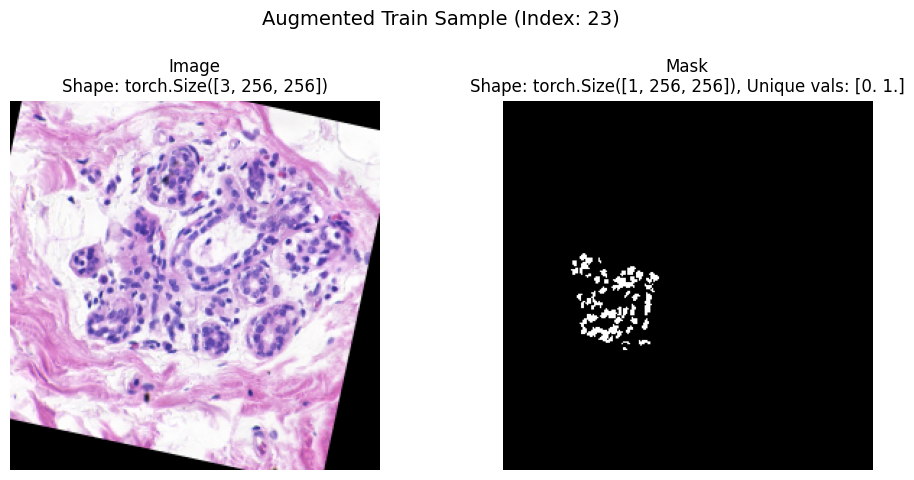

In [40]:
# --- Create Augmented Datasets and DataLoaders ---

# Create new training dataset instance with augmentations
# Ensure CancerCellDataset class is available
train_dataset_augmented = CancerCellDataset(
    IMAGE_DIR, MASK_DIR, train_samples,
    transform=train_transform_augmented,
    foreground_threshold=FOREGROUND_THRESHOLD
)

# Validation and Test datasets can use the non-augmented transform
# If val_dataset/test_dataset from Part 1 used the same simple transform, reuse them.
# Otherwise, recreate them:
if 'val_dataset' not in locals() or val_dataset.transform != val_test_transform:
    print("Recreating val_dataset with val_test_transform")
    val_dataset = CancerCellDataset(IMAGE_DIR, MASK_DIR, val_samples, transform=val_test_transform, foreground_threshold=FOREGROUND_THRESHOLD)
if 'test_dataset' not in locals() or test_dataset.transform != val_test_transform:
     print("Recreating test_dataset with val_test_transform")
     test_dataset = CancerCellDataset(IMAGE_DIR, MASK_DIR, test_samples, transform=val_test_transform, foreground_threshold=FOREGROUND_THRESHOLD)


# Create new DataLoaders for augmented training
train_loader_augmented = DataLoader(
    train_dataset_augmented,
    batch_size=BATCH_SIZE, # Use BATCH_SIZE from previous parts
    shuffle=True,
    num_workers=NUM_WORKERS, # Use NUM_WORKERS from previous parts
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    drop_last=True
)

# Reuse or recreate val/test loaders if needed
if 'val_loader' not in locals():
     print("Recreating val_loader")
     val_loader = DataLoader(
          val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=NUM_WORKERS,
          pin_memory=True, persistent_workers=True if NUM_WORKERS > 0 else False
     )
if 'test_loader' not in locals():
     print("Recreating test_loader")
     test_loader = DataLoader(
          test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=NUM_WORKERS,
          pin_memory=True, persistent_workers=True if NUM_WORKERS > 0 else False
     )


print(f"\nAugmented Training Dataset: {len(train_dataset_augmented)} samples")
print(f"Augmented Training DataLoader: {len(train_loader_augmented)} batches")

# Visualize a sample from the *augmented* dataset
print("\nVisualizing a sample from the *augmented* training dataset:")
# Ensure visualize_sample function is available
visualize_sample(train_dataset_augmented, index=np.random.randint(len(train_dataset_augmented)), title="Augmented Train Sample")


In [41]:
# --- Prepare Models for Training ---

# 1. Get the best loss function from Part 3.1 results
if 'best_loss_name' not in locals() or best_loss_name is None:
    print("Warning: 'best_loss_name' not found from Part 3.1. Defaulting to 'Dice'.")
    best_loss_name = 'Dice' # Default if not found
    if best_loss_name not in loss_functions:
         # If even Dice isn't defined, pick the first available
         best_loss_name = list(loss_functions.keys())[0]

best_loss_fn = loss_functions[best_loss_name]
print(f"\nUsing Loss Function: '{best_loss_name}'")

# 2. Define models to train
models_to_train_aug = {}

# Add U-Net (create a new instance)
# Ensure UNet class definition is available
models_to_train_aug['UNet_Aug'] = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
print("Added U-Net (new instance) to training list.")

# Add PSPNet (if library is available)
if SMP_AVAILABLE:
    try:
        pspnet_model = smp.PSPNet(
            encoder_name="resnet34",        # Common choice, balances performance and size
            encoder_weights="imagenet",     # Use pretrained weights
            in_channels=N_INPUT_CHANNELS,   # Should be 3
            classes=N_CLASSES,              # Should be 1 for binary
            # activation=None,              # No activation needed, raw logits output
        )
        models_to_train_aug['PSPNet_Aug'] = pspnet_model
        print("Added PSPNet (resnet34, imagenet weights) to training list.")
    except Exception as e:
        print(f"Error creating PSPNet model: {e}")
        print("PSPNet will not be trained.")
else:
    print("Skipping PSPNet training because segmentation-models-pytorch is not available.")



Using Loss Function: 'Dice'
Added U-Net (new instance) to training list.
Added PSPNet (resnet34, imagenet weights) to training list.


In [42]:
# --- Training Loop for Augmented Data ---

trained_models_aug_paths = {}
validation_results_aug = {}

for model_name, model_arch_instance in models_to_train_aug.items():
    print(f"\n--- Training {model_name} with Augmentations & Loss: {best_loss_name} ---")

    # 1. Instantiate Lightning Module with the current model architecture
    lightning_model_aug = CancerSegmentationModule(
        model_arch=model_arch_instance,
        loss_fn=best_loss_fn,
        learning_rate=LEARNING_RATE # Use LEARNING_RATE from previous parts
    )

    # 2. Configure Callbacks (use new directory/filenames)
    checkpoint_callback_aug = ModelCheckpoint(
        monitor='val_dice',
        dirpath=CHECKPOINT_DIR_AUG,
        filename=f'{model_name}_best_dice={{val_dice:.4f}}', # Include model name
        save_top_k=1,
        mode='max',
        save_last=True
    )
    early_stop_callback_aug = EarlyStopping(
        monitor='val_dice',
        patience=AUG_PATIENCE, # Use increased patience
        verbose=True,
        mode='max'
    )

    # 3. Configure Logger (use new directory/name)
    tensorboard_logger_aug = TensorBoardLogger(
        save_dir=LOG_DIR_AUG,
        name=f"{model_name}_{best_loss_name}_aug" # Detailed name
    )

    # 4. Configure Trainer
    trainer_aug = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        max_epochs=AUG_MAX_EPOCHS, # Use increased epochs
        callbacks=[checkpoint_callback_aug, early_stop_callback_aug],
        logger=tensorboard_logger_aug,
        log_every_n_steps=10,
        deterministic=False,
        precision='16-mixed' if torch.cuda.is_available() else 32,
        enable_progress_bar=False # Keep progress bar disabled as requested
    )

    # 5. Start Training
    print(f"Starting training for {model_name}...")
    trainer_aug.fit(lightning_model_aug, train_dataloaders=train_loader_augmented, val_dataloaders=val_loader)

    # 6. Store best model path and evaluate on validation set
    best_path_aug = checkpoint_callback_aug.best_model_path
    model_saved_path = None # Track which path we actually use

    if best_path_aug and os.path.exists(best_path_aug):
        print(f"Best model checkpoint for {model_name} saved at: {best_path_aug}")
        model_saved_path = best_path_aug
    else:
        print(f"Could not find the best checkpoint path for {model_name}. Checking last checkpoint.")
        last_path_aug = checkpoint_callback_aug.last_model_path
        if last_path_aug and os.path.exists(last_path_aug):
            print(f"Using last checkpoint for {model_name}: {last_path_aug}")
            model_saved_path = last_path_aug
        else:
            print(f"Neither best nor last checkpoint found for {model_name}. Cannot validate.")

    trained_models_aug_paths[model_name] = model_saved_path

    if model_saved_path:
        print(f"Validating {model_name} model from: {model_saved_path}")
        # Need to instantiate the correct architecture again for loading
        # Important: Use the specific architecture (U-Net or PSPNet)
        try:
            if 'UNet' in model_name:
                 arch_instance_load = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
            elif 'PSPNet' in model_name and SMP_AVAILABLE:
                 # Recreate PSPNet structure; weights will be loaded from checkpoint
                 # Use same encoder, classes, channels. Set weights=None to avoid conflicts.
                 arch_instance_load = smp.PSPNet(
                     encoder_name="resnet34", # Must match the trained encoder
                     encoder_weights=None,    # Load weights from checkpoint, not imagenet
                     in_channels=N_INPUT_CHANNELS,
                     classes=N_CLASSES
                 )
            else:
                 raise ValueError(f"Unknown model architecture for loading: {model_name}")

            loaded_model_aug = CancerSegmentationModule.load_from_checkpoint(
                checkpoint_path=model_saved_path,
                model_arch=arch_instance_load,
                loss_fn=best_loss_fn # Pass loss function
            )
            val_result_aug = trainer_aug.validate(loaded_model_aug, dataloaders=val_loader, verbose=False)
            if val_result_aug:
                validation_results_aug[model_name] = val_result_aug[0]
                print(f"Validation results for {model_name}: {val_result_aug[0]}")
            else:
                print(f"Validation returned empty results for {model_name}.")
                validation_results_aug[model_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
            del loaded_model_aug, arch_instance_load # Clean up loaded model

        except Exception as e:
             print(f"Error loading or validating {model_name} from {model_saved_path}: {e}")
             validation_results_aug[model_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
    else:
         validation_results_aug[model_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}


    # 7. Clean up memory
    del model_arch_instance, lightning_model_aug, trainer_aug
    del checkpoint_callback_aug, early_stop_callback_aug, tensorboard_logger_aug
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Training UNet_Aug with Augmentations & Loss: Dice ---
Starting training for UNet_Aug...



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNet               | 17.3 M | train
1 | loss_fn   | DiceLoss           | 0      | eval 
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)
99        Modules in train mode
1         Modules in eval mode
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Metric val_dice improved. New best score:

Best model checkpoint for UNet_Aug saved at: /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1367.ckpt
Validating UNet_Aug model from: /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1367.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alex/ML/checkpoints_part4_aug exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PSPNet             | 21.4 M | train
1 | loss_fn   | DiceLoss           | 0      | eval 
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.752

Validation results for UNet_Aug: {'val_loss': 0.8679772615432739, 'val_dice': 0.13670852780342102, 'val_iou': 0.13516367971897125}

--- Training PSPNet_Aug with Augmentations & Loss: Dice ---
Starting training for PSPNet_Aug...


Metric val_dice improved. New best score: 0.035
Metric val_dice improved by 0.004 >= min_delta = 0.0. New best score: 0.038
Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.044
Metric val_dice improved by 0.008 >= min_delta = 0.0. New best score: 0.052
Metric val_dice improved by 0.009 >= min_delta = 0.0. New best score: 0.062
Metric val_dice improved by 0.011 >= min_delta = 0.0. New best score: 0.072
Metric val_dice improved by 0.008 >= min_delta = 0.0. New best score: 0.081
Metric val_dice improved by 0.007 >= min_delta = 0.0. New best score: 0.087
Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.093
Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.095
Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.097
Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.097
Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.103
Monitored metric val_dice did not improv

Best model checkpoint for PSPNet_Aug saved at: /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.1035.ckpt
Validating PSPNet_Aug model from: /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.1035.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation results for PSPNet_Aug: {'val_loss': 0.8535041213035583, 'val_dice': 0.1034892275929451, 'val_iou': 0.09779306501150131}


In [43]:
# --- Summarize Augmented Training Results ---

print("\n--- Augmented Training Summary ---")
print("Paths to best/last saved models (Augmented Training):")
for name, path in trained_models_aug_paths.items():
    print(f"- {name}: {path if path else 'Not saved/found'}")

print("\nValidation Results (Augmented Training):")
if validation_results_aug:
    results_df_aug = pd.DataFrame(validation_results_aug).T
    # Rename columns for clarity
    if 'val_dice' in results_df_aug.columns:
        results_df_aug = results_df_aug.rename(columns={
            'val_loss': 'Validation Loss',
            'val_dice': 'Validation Dice',
            'val_iou': 'Validation IoU'
        })
    print(results_df_aug.to_string(float_format="%.4f"))
else:
    print("No validation results were collected for augmented training.")


--- Augmented Training Summary ---
Paths to best/last saved models (Augmented Training):
- UNet_Aug: /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1367.ckpt
- PSPNet_Aug: /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.1035.ckpt

Validation Results (Augmented Training):
            Validation Loss  Validation Dice  Validation IoU
UNet_Aug             0.8680           0.1367          0.1352
PSPNet_Aug           0.8535           0.1035          0.0978


In [44]:
# Imports (ensure they are available from previous cells)
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import gc
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd # For displaying results if needed

# Try importing smp again in case this cell is run independently
try:
    import segmentation_models_pytorch as smp
    SMP_AVAILABLE = True
except ImportError:
    SMP_AVAILABLE = False


# Ensure necessary variables/classes from previous parts are available:
# device, UNet, CancerSegmentationModule, CancerCellDataset
# test_dataset, test_loader
# trained_models_aug_paths (from Part 4 training loop)
# validation_results_aug (from Part 4 training loop)
# best_loss_name, loss_functions
# N_INPUT_CHANNELS, N_CLASSES, IMG_HEIGHT, IMG_WIDTH
# LOG_DIR_AUG (from Part 4 setup)

print("\n--- Part 4.1: Visualizing Augmented Training Results ---")



--- Part 4.1: Visualizing Augmented Training Results ---


In [45]:
# --- Load Models Trained in Part 4 ---
# This dictionary will hold the successfully loaded models
loaded_models_part4 = {}

# Check if the paths dictionary exists from Part 4 execution
if 'trained_models_aug_paths' in locals() and trained_models_aug_paths:
    for model_name, model_path in trained_models_aug_paths.items():
        # Check if path exists and is valid
        if model_path and os.path.exists(model_path):
            print(f"\nLoading model '{model_name}' from: {model_path}")
            try:
                # Select the correct architecture to instantiate
                if 'UNet_Aug' in model_name:
                    # Ensure UNet class is defined
                    arch_instance_load = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
                elif 'PSPNet_Aug' in model_name and SMP_AVAILABLE:
                    # Ensure smp is imported and PSPNet can be created
                    # Must match the configuration used during training (e.g., encoder)
                    arch_instance_load = smp.PSPNet(
                        encoder_name="resnet34", # This MUST match the encoder used in Part 4 training
                        encoder_weights=None,    # Weights are loaded from checkpoint
                        in_channels=N_INPUT_CHANNELS,
                        classes=N_CLASSES
                    )
                else:
                     print(f"Warning: Skipping load for '{model_name}'. Unknown architecture or SMP not available.")
                     continue # Skip to next model

                # Get the loss function instance used for training (needed by load_from_checkpoint)
                # Assumes 'best_loss_name' and 'loss_functions' are available from Part 3 / Part 4 setup
                loss_fn_instance = loss_functions[best_loss_name]

                # Load the LightningModule from the checkpoint
                loaded_model = CancerSegmentationModule.load_from_checkpoint(
                    checkpoint_path=model_path,
                    model_arch=arch_instance_load, # Pass the instantiated architecture
                    loss_fn=loss_fn_instance      # Pass the loss function object
                )
                loaded_models_part4[model_name] = loaded_model # Store the loaded model
                print(f"Model '{model_name}' loaded successfully.")

            except Exception as e:
                # Catch potential errors during loading (e.g., architecture mismatch, corrupted file)
                print(f"Error loading model '{model_name}' from {model_path}: {e}")
                # Ensure the model isn't added to the dictionary if loading failed
                if model_name in loaded_models_part4:
                    del loaded_models_part4[model_name]
        else:
            # Handle cases where the path was not saved or file doesn't exist
            print(f"Model path not found or invalid for '{model_name}': {model_path}. Skipping load.")
else:
    print("Warning: 'trained_models_aug_paths' dictionary not found or empty. Cannot load models for visualization.")



Loading model 'UNet_Aug' from: /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1367.ckpt
Model 'UNet_Aug' loaded successfully.

Loading model 'PSPNet_Aug' from: /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.1035.ckpt
Model 'PSPNet_Aug' loaded successfully.



Visualizing prediction comparison for Part 4 models on indices: [8, 10, 0]


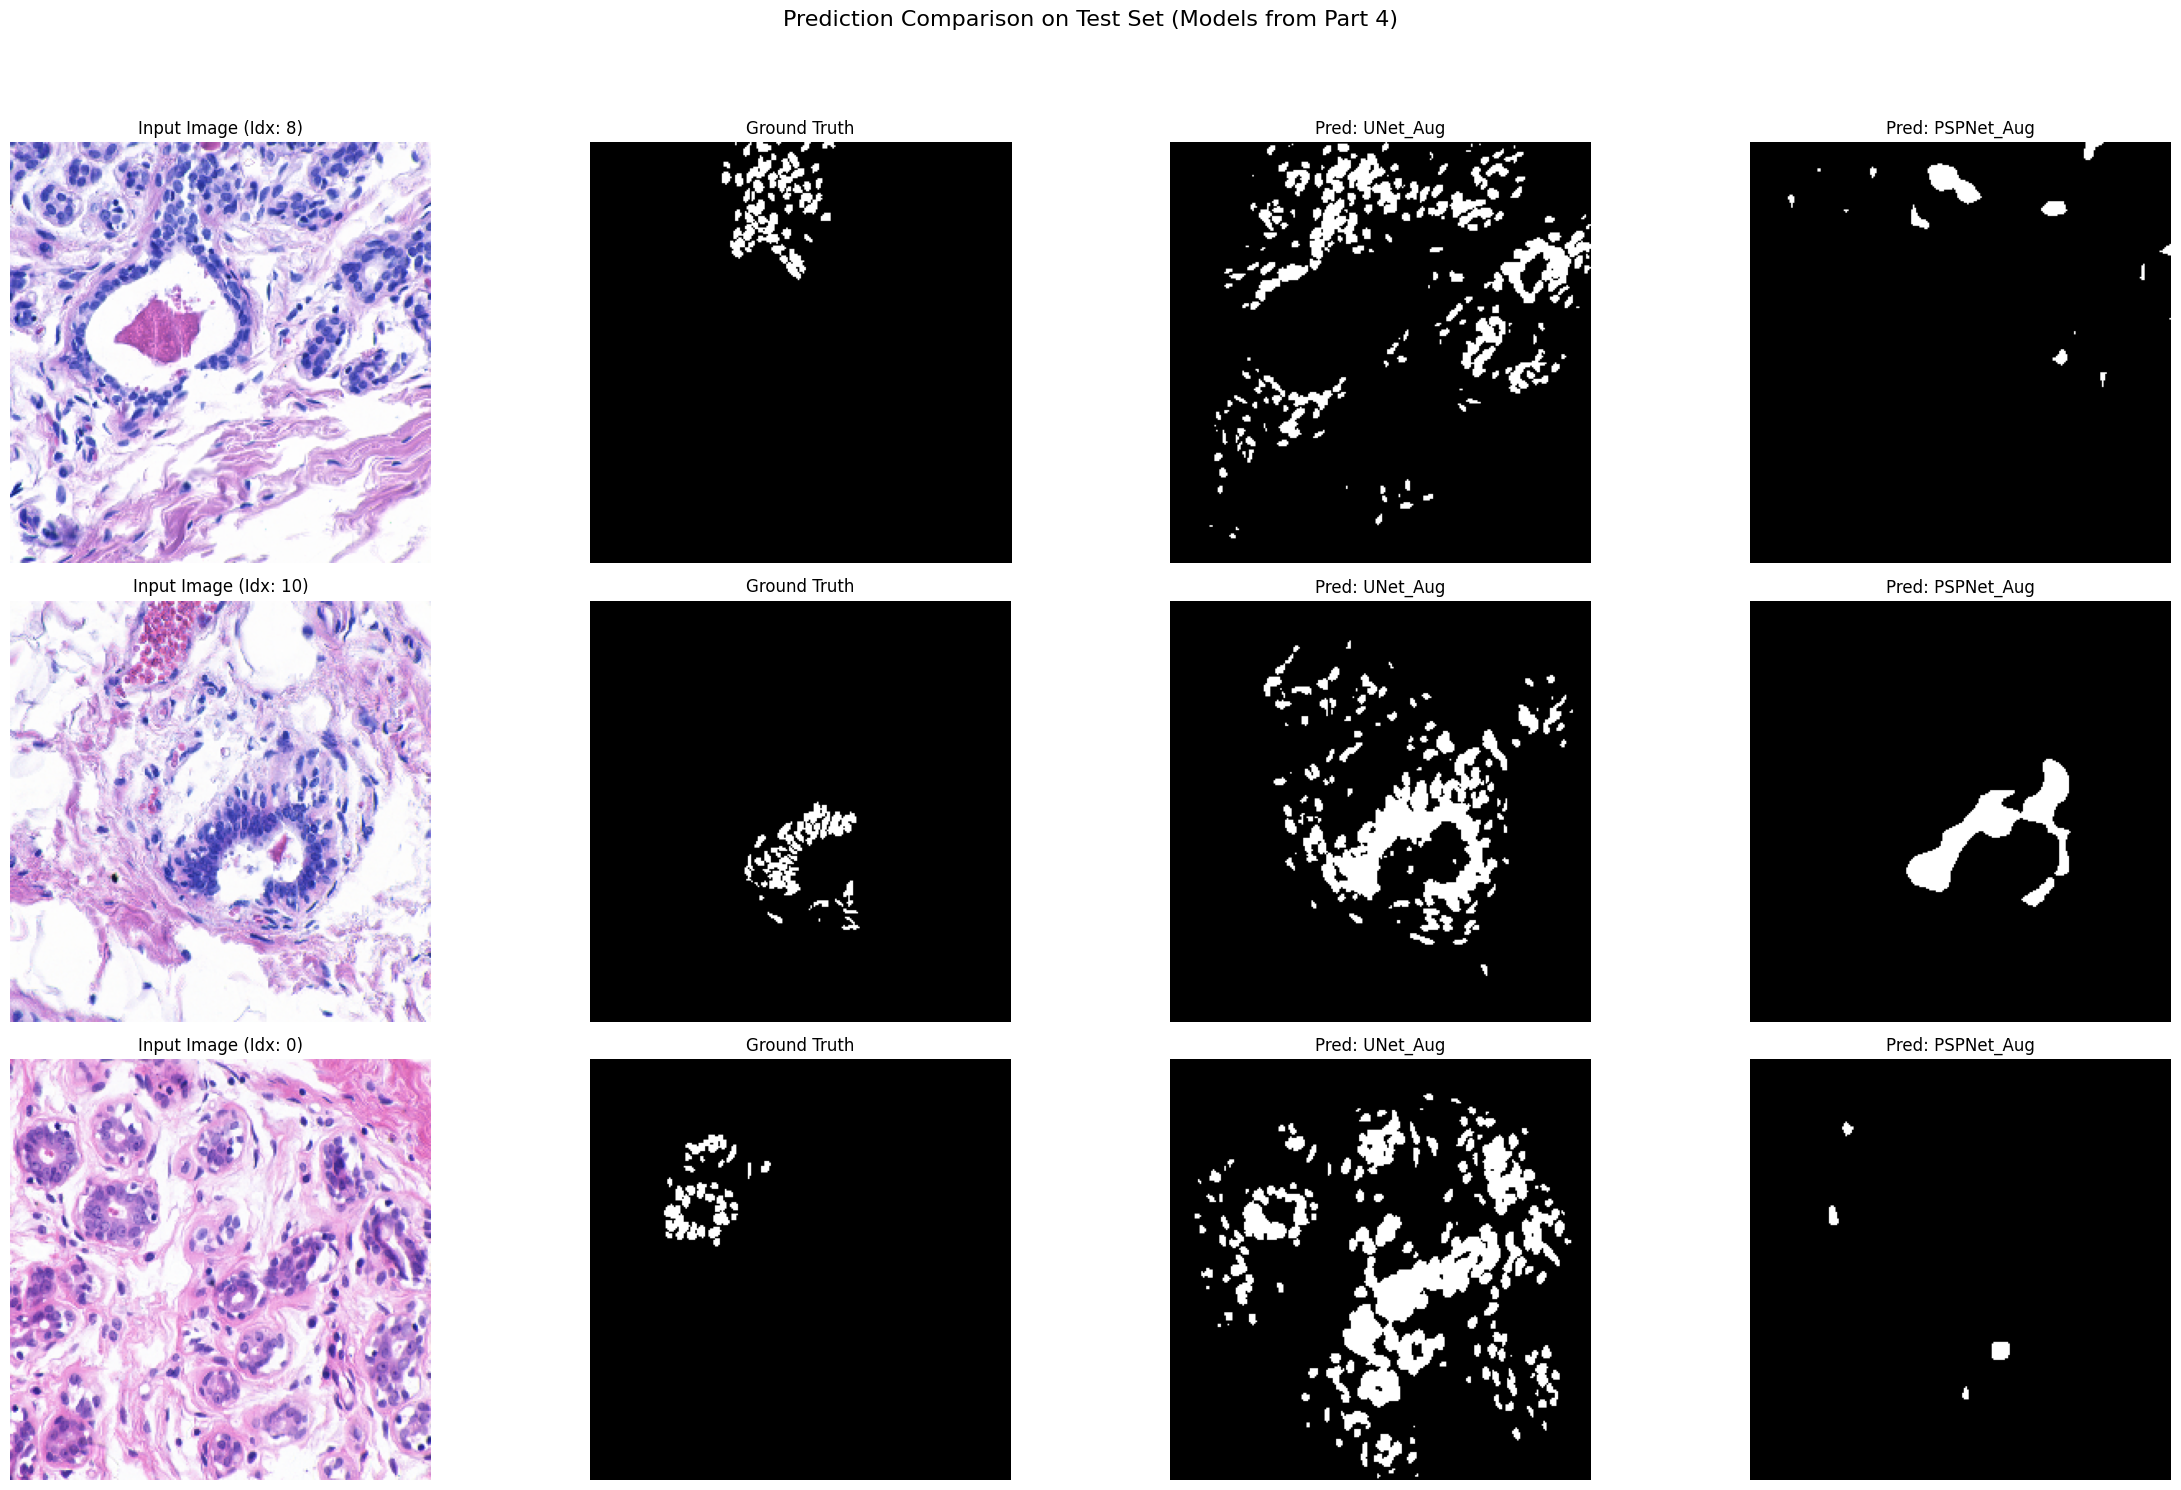

In [46]:
# --- Visualize Predictions Comparison ---
# Reuse the plotting function from Part 3.1 if suitable, or define again
# Let's use a slightly adapted version for clarity

def plot_predictions_part4(models_dict, dataset, indices, device, num_samples=3):
    """Plots input, ground truth, and predictions from multiple models trained in Part 4."""
    if not models_dict:
        print("Cannot plot predictions: No models loaded from Part 4.")
        return
    if not indices:
         print("Cannot plot predictions: No indices provided.")
         return

    num_models = len(models_dict)
    # Adjust figsize based on number of models
    plt.figure(figsize=(6 * (2 + num_models), 5 * num_samples))
    plt.suptitle(f"Prediction Comparison on Test Set (Models from Part 4)", fontsize=16, y=1.02)

    plot_row_idx = 0
    for i, data_idx in enumerate(indices):
        try:
            image, mask_gt = dataset[data_idx] # Get tensor sample from test_dataset

            # --- Prepare data for plotting ---
            # Denormalize image for display
            image_display = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_display = std * image_display + mean
            image_display = np.clip(image_display, 0, 1)
            # Ground truth mask
            mask_gt_display = mask_gt.squeeze().cpu().numpy() # Remove channel dim

            # --- Plot Input and Ground Truth ---
            base_plot_idx = plot_row_idx * (2 + num_models) + 1
            plt.subplot(num_samples, 2 + num_models, base_plot_idx)
            plt.imshow(image_display)
            plt.title(f"Input Image (Idx: {data_idx})")
            plt.axis('off')

            plt.subplot(num_samples, 2 + num_models, base_plot_idx + 1)
            plt.imshow(mask_gt_display, cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            # --- Plot Predictions for each loaded model ---
            model_plot_offset = 0
            for model_name, model in models_dict.items():
                model.eval() # Ensure evaluation mode
                model.to(device)
                # Prepare image for model input (add batch dim)
                image_input = image.unsqueeze(0).to(device)

                # Get prediction
                with torch.no_grad():
                    logits = model(image_input)
                    preds_prob = torch.sigmoid(logits) # Apply sigmoid to get probabilities
                    # Threshold probabilities to get binary mask
                    preds_binary = (preds_prob > 0.5).squeeze().cpu().numpy()

                # Plot the prediction
                plt.subplot(num_samples, 2 + num_models, base_plot_idx + 2 + model_plot_offset)
                plt.imshow(preds_binary, cmap='gray')
                plt.title(f"Pred: {model_name}")
                plt.axis('off')
                model_plot_offset += 1

            plot_row_idx += 1 # Move to the next row of subplots

        except Exception as e:
            print(f"Error visualizing sample index {data_idx} for Part 4 models: {e}")
            # Optionally add error placeholders in the plot grid

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
    plt.show()


# Select samples and run plotting function for Part 4 models
if loaded_models_part4 and 'test_dataset' in locals() and len(test_dataset) > 0:
    num_viz_samples = min(3, len(test_dataset)) # Visualize up to 3 samples
    # Choose random indices from the test set
    plot_indices_part4 = np.random.choice(len(test_dataset), num_viz_samples, replace=False).tolist()
    print(f"\nVisualizing prediction comparison for Part 4 models on indices: {plot_indices_part4}")
    plot_predictions_part4(loaded_models_part4, test_dataset, plot_indices_part4, device, num_samples=num_viz_samples)
else:
    print("\nSkipping prediction visualization for Part 4 models (no models loaded or test_dataset missing/empty).")



--- Plotting Training Curves (Part 4: Augmented Training) ---
Reading 'val_loss' logs for 'U-Net (Aug)' from: tb_logs_part4_aug/UNet_Aug_Dice_aug/version_0
Reading 'val_loss' logs for 'PSPNet (Aug)' from: tb_logs_part4_aug/PSPNet_Aug_Dice_aug/version_0
Reading 'val_dice' logs for 'U-Net (Aug)' from: tb_logs_part4_aug/UNet_Aug_Dice_aug/version_0
Reading 'val_dice' logs for 'PSPNet (Aug)' from: tb_logs_part4_aug/PSPNet_Aug_Dice_aug/version_0
Reading 'val_iou' logs for 'U-Net (Aug)' from: tb_logs_part4_aug/UNet_Aug_Dice_aug/version_0
Reading 'val_iou' logs for 'PSPNet (Aug)' from: tb_logs_part4_aug/PSPNet_Aug_Dice_aug/version_0
Reading 'train_loss_epoch' logs for 'U-Net (Aug)' from: tb_logs_part4_aug/UNet_Aug_Dice_aug/version_0
Reading 'train_loss_epoch' logs for 'PSPNet (Aug)' from: tb_logs_part4_aug/PSPNet_Aug_Dice_aug/version_0


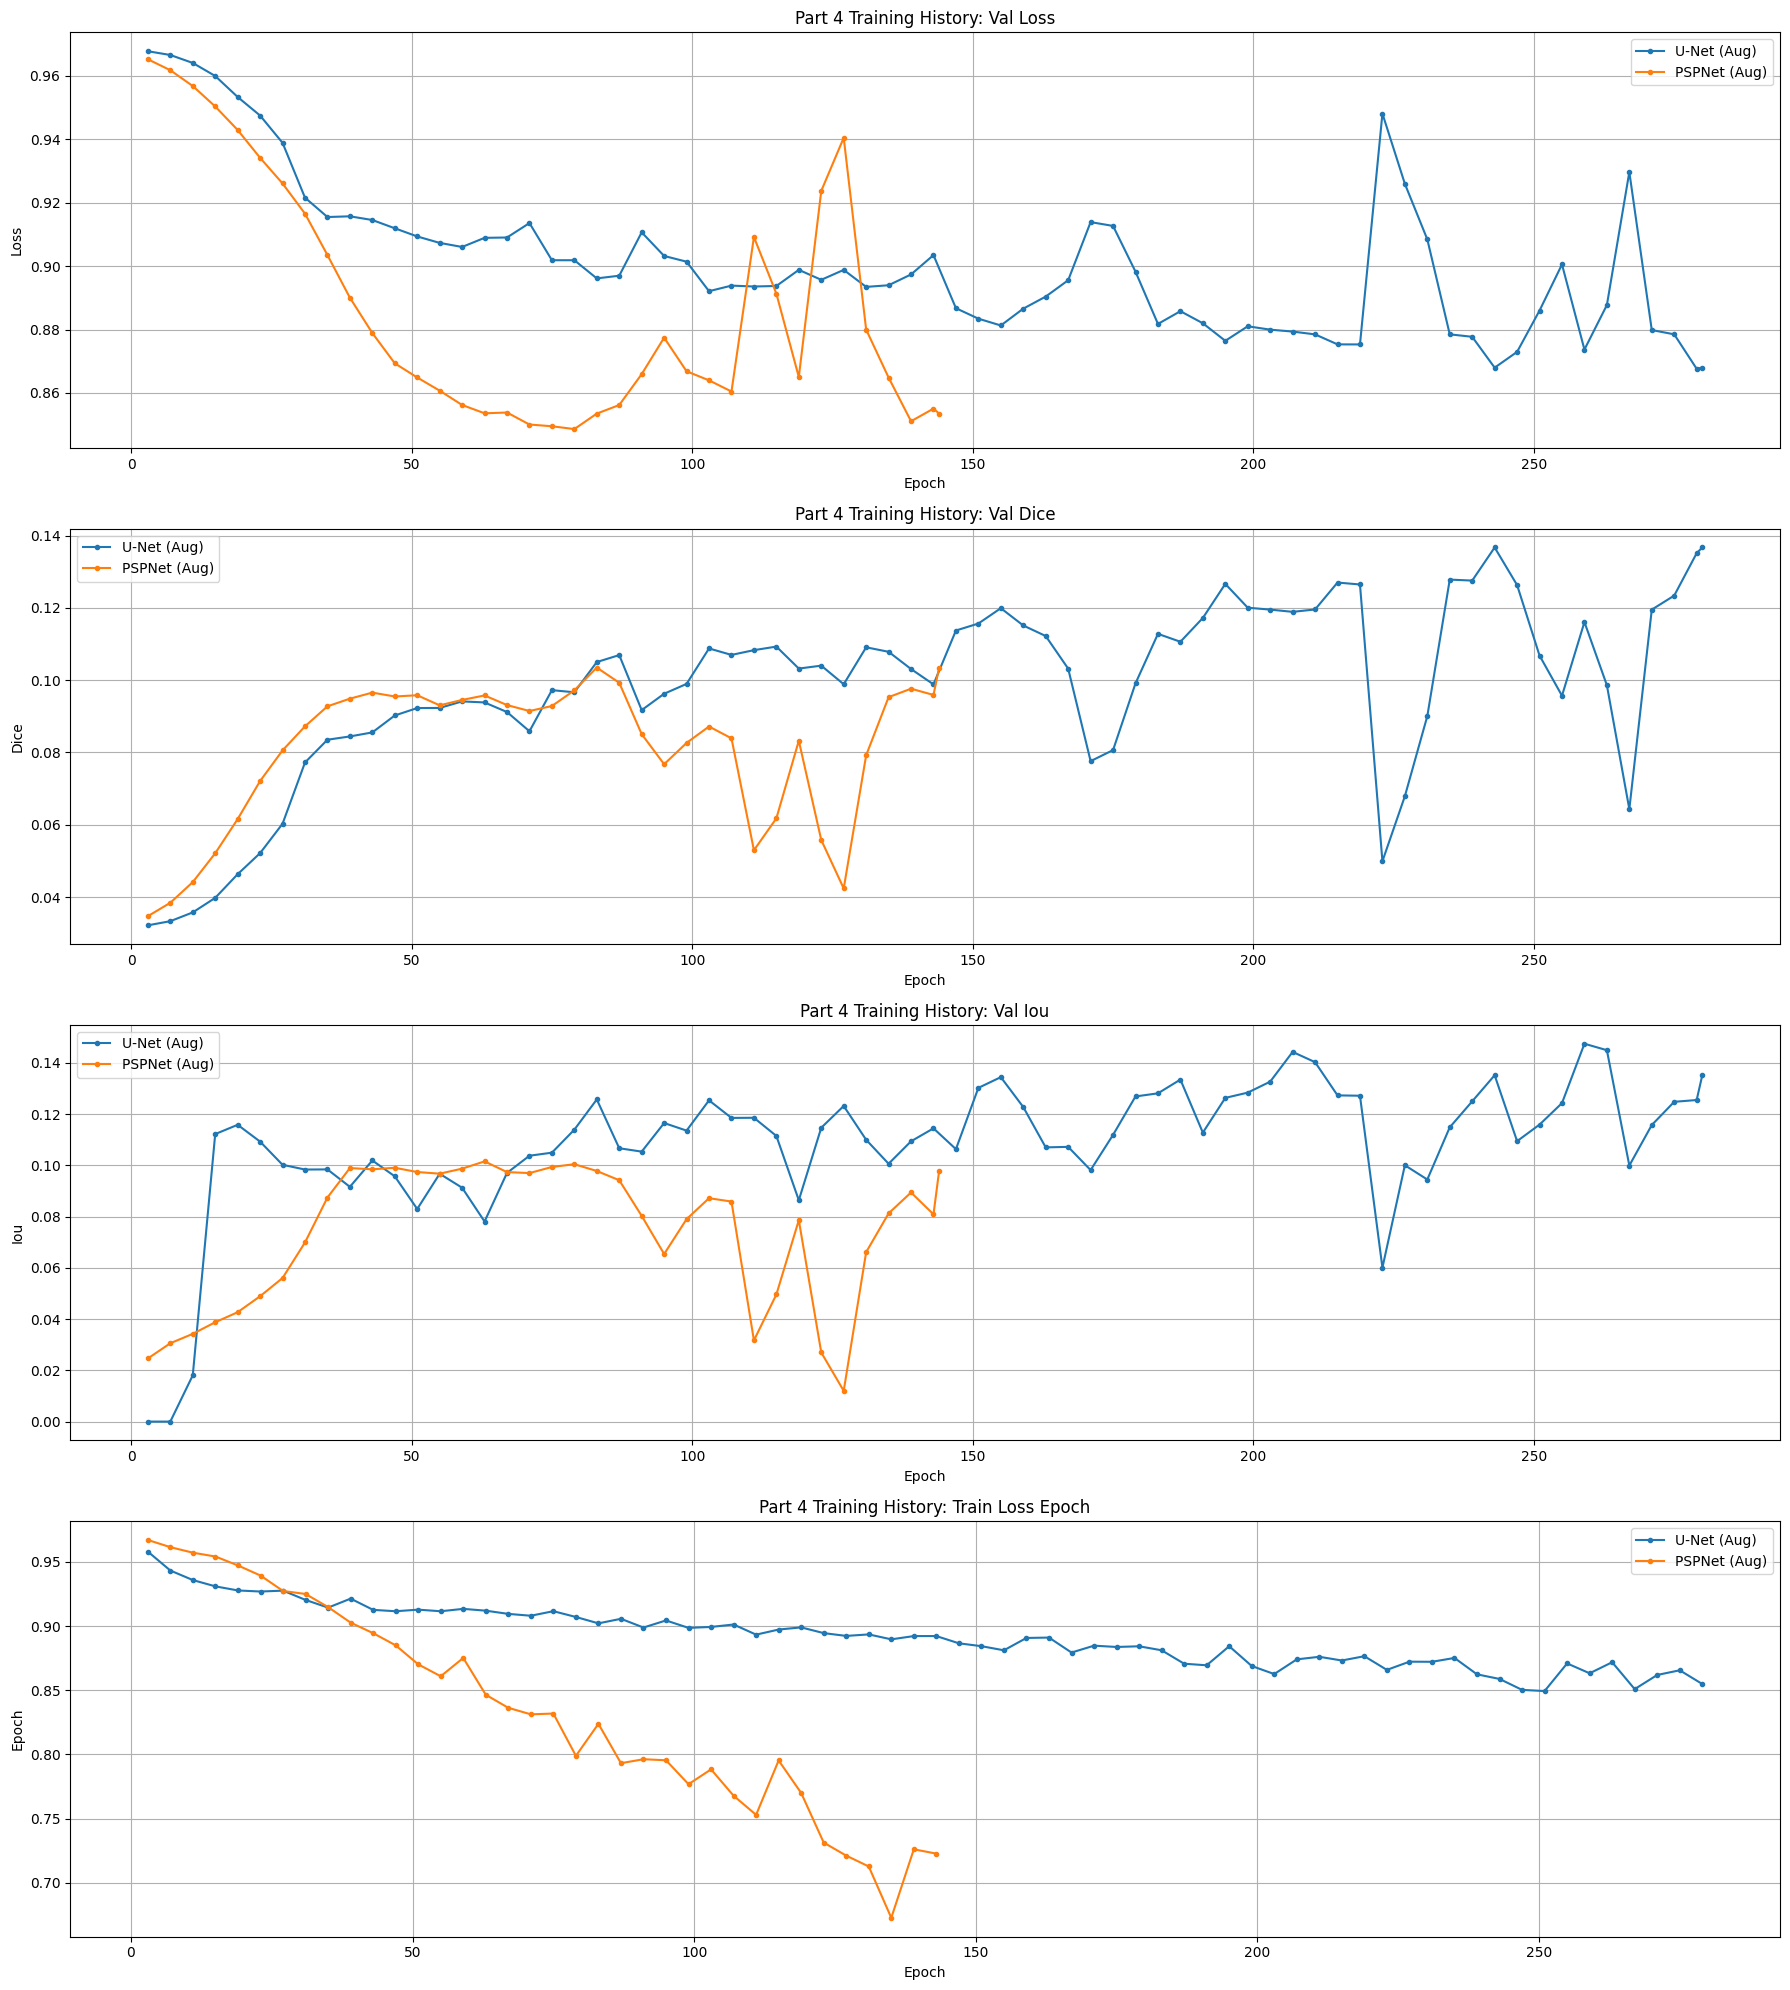

In [47]:
# --- Plot Training Curves from Part 4 (Augmented Training) ---
# Reuse the logic from Part 3.1, but point to LOG_DIR_AUG and use model names from Part 4

print("\n--- Plotting Training Curves (Part 4: Augmented Training) ---")
# LOG_DIR_AUG should be defined in the main Part 4 script setup
log_dir_base_part4 = LOG_DIR_AUG
if 'log_dir_base_part4' not in locals() or not os.path.exists(log_dir_base_part4):
     print(f"Error: Log directory '{log_dir_base_part4}' not found. Cannot plot curves for Part 4.")
else:
    # Identify the log subdirectories corresponding to the models trained in Part 4
    configs_to_plot_part4 = {}
    # Assumes trained_models_aug_paths keys are 'UNet_Aug', 'PSPNet_Aug' etc.
    # Assumes best_loss_name is available
    if 'UNet_Aug' in trained_models_aug_paths: # Check if UNet was trained
         configs_to_plot_part4['U-Net (Aug)'] = f"UNet_Aug_{best_loss_name}_aug"
    if 'PSPNet_Aug' in trained_models_aug_paths: # Check if PSPNet was trained
         configs_to_plot_part4['PSPNet (Aug)'] = f"PSPNet_Aug_{best_loss_name}_aug"

    if not configs_to_plot_part4:
         print("No model configurations found to plot for Part 4.")
    else:
        metrics_to_plot = ['val_loss', 'val_dice', 'val_iou', 'train_loss_epoch'] # Metrics to try plotting

        # Determine number of subplots needed (only for metrics found in logs)
        num_subplots = 0
        plotable_metrics = []
        for metric in metrics_to_plot:
            metric_found = False
            for config_name, log_pattern in configs_to_plot_part4.items():
                 # Quick check if log dir exists and potentially contains the metric
                 possible_log_dir = os.path.join(log_dir_base_part4, log_pattern)
                 if os.path.exists(possible_log_dir):
                     version_dirs = sorted([d for d in os.listdir(possible_log_dir) if d.startswith('version_')])
                     if version_dirs:
                         try:
                             # A more robust check would involve EventAccumulator, but this is faster
                             # We'll handle missing tags gracefully during plotting anyway
                             metric_found = True # Assume it might exist if log dir is there
                             break
                         except Exception: pass
            if metric_found:
                 num_subplots += 1
                 plotable_metrics.append(metric)

        if num_subplots == 0:
            print("No plottable metrics found in logs for Part 4 models.")
        else:
            plt.figure(figsize=(18, 5 * num_subplots)) # Adjust figure size based on actual metrics
            plot_num = 1
            for metric in plotable_metrics: # Iterate only over metrics likely to exist
                ax = plt.subplot(num_subplots, 1, plot_num) # Create subplot
                plt.title(f"Part 4 Training History: {metric.replace('_', ' ').title()}")
                plt.xlabel("Epoch")
                plt.ylabel(metric.split('_')[-1].capitalize())
                plt.grid(True)
                has_data_for_metric_plot = False # Flag to check if any curve was plotted

                # Iterate through the configurations (U-Net Aug, PSPNet Aug)
                for config_name, log_pattern in configs_to_plot_part4.items():
                    full_log_dir = None
                    # Find the latest version directory for this configuration
                    loss_log_base = os.path.join(log_dir_base_part4, log_pattern)
                    if os.path.exists(loss_log_base):
                        version_dirs = sorted([d for d in os.listdir(loss_log_base) if d.startswith('version_')])
                        if version_dirs:
                            full_log_dir = os.path.join(loss_log_base, version_dirs[-1]) # Latest version

                    if full_log_dir and os.path.exists(full_log_dir):
                        print(f"Reading '{metric}' logs for '{config_name}' from: {full_log_dir}")
                        try:
                            # Load events from the log directory
                            event_acc = EventAccumulator(full_log_dir)
                            event_acc.Reload()

                            # Check if the specific metric tag exists in this log file
                            if metric in event_acc.Tags()['scalars']:
                                events = event_acc.Scalars(metric)
                                # Extract steps (epochs) and values
                                steps = [e.step for e in events]
                                values = [e.value for e in events]
                                # Plot if data exists
                                if steps and values:
                                    plt.plot(steps, values, marker='.', linestyle='-', label=config_name)
                                    has_data_for_metric_plot = True
                            # else: print(f"  - Tag '{metric}' not found.") # Optional debug msg

                        except Exception as e:
                            print(f"  - Error reading logs for {config_name}: {e}")
                    # else: print(f"Log directory not found for {config_name}: {full_log_dir}") # Optional debug msg

                # Add legend only if some data was plotted for this metric
                if has_data_for_metric_plot:
                     plt.legend()
                     plot_num += 1 # Increment subplot index only if we plotted something
                else:
                     # If no data plotted, add text to the empty subplot
                     plt.text(0.5, 0.5, f'No data found for {metric}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                     plot_num += 1 # Still increment plot_num to use the next subplot space correctly


            plt.tight_layout()
            plt.show()


In [48]:
# --- Clean up loaded models from Part 4 ---
if 'loaded_models_part4' in locals():
    del loaded_models_part4
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Part 4.2: Augmentations and advanced model conclusion

Compare three setups:
- Unet without augmentations (with best loss)
- Unet with augmentations
- Advanced model with augmentations

_Hint: with augs and more complex model you may want to have more iterations._

Save all three trained models to disk!

Once again provide comprehensive arguments and your insights.

Wich setup is better?

Compute losses and metrics on test set. Measure improvement over first test evaluation.

In [56]:
# Imports (ensure availability)
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

# Try importing smp again
try:
    import segmentation_models_pytorch as smp
    SMP_AVAILABLE = True
except ImportError:
    SMP_AVAILABLE = False

# Ensure necessary variables/classes from previous parts are available:
# device, UNet, CancerSegmentationModule, CancerCellDataset, evaluate_model_on_test (from 3.1)
# test_loader, test_dataset
# best_loss_name, loss_functions
# trained_models_paths (from Part 3), trained_models_aug_paths (from Part 4)
# N_INPUT_CHANNELS, N_CLASSES, IMG_HEIGHT, IMG_WIDTH
# test_results_best_model (from Part 3.1, contains baseline test scores)

print("\n--- Part 4.2: Comparison and Conclusion ---")



--- Part 4.2: Comparison and Conclusion ---


In [57]:
# --- Identify Models and Paths for Comparison ---
models_to_compare = {}
paths_to_compare = {}

# 1. Baseline: Best U-Net without Augmentations (from Part 3)
if 'best_loss_name' in locals() and 'trained_models_paths' in locals() and best_loss_name in trained_models_paths:
    baseline_path = trained_models_paths.get(best_loss_name)
    if baseline_path and os.path.exists(baseline_path):
        model_key = f"U-Net (No Aug, {best_loss_name})"
        paths_to_compare[model_key] = baseline_path
    else:
        print(f"Warning: Baseline model path not found for {best_loss_name}.")
else:
    print("Warning: Baseline model information (best_loss_name or paths) not found.")

# 2. U-Net with Augmentations (from Part 4)
if 'trained_models_aug_paths' in locals() and 'UNet_Aug' in trained_models_aug_paths:
    unet_aug_path = trained_models_aug_paths.get('UNet_Aug')
    if unet_aug_path and os.path.exists(unet_aug_path):
         model_key = f"U-Net (Aug, {best_loss_name})"
         paths_to_compare[model_key] = unet_aug_path
    else:
        print("Warning: U-Net (Aug) model path not found.")
else:
    print("Warning: U-Net (Aug) results not found.")

# 3. Advanced Model (PSPNet) with Augmentations (from Part 4)
if 'trained_models_aug_paths' in locals() and 'PSPNet_Aug' in trained_models_aug_paths:
     pspnet_aug_path = trained_models_aug_paths.get('PSPNet_Aug')
     if pspnet_aug_path and os.path.exists(pspnet_aug_path):
         model_key = f"PSPNet (Aug, {best_loss_name})"
         paths_to_compare[model_key] = pspnet_aug_path
     else:
         print("Warning: PSPNet (Aug) model path not found.")
elif SMP_AVAILABLE:
     print("Warning: PSPNet (Aug) results not found (was it trained successfully?).")
# No warning needed if SMP wasn't available from the start

if not paths_to_compare:
    raise RuntimeError("No models found to compare. Ensure Parts 3 and 4 were run successfully and paths were saved.")

print("\nModels selected for final comparison:")
for name, path in paths_to_compare.items():
    print(f"- {name}: {path}")



Models selected for final comparison:
- U-Net (No Aug, Dice): /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0761.ckpt
- U-Net (Aug, Dice): /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1367.ckpt
- PSPNet (Aug, Dice): /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.1035.ckpt


In [58]:
# --- Evaluate Selected Models on Test Set ---
final_test_results = {}
loaded_models_final = {} # Store loaded models for potential visualization

# Get the best loss function instance
loss_fn_instance = loss_functions[best_loss_name]

print("\n--- Evaluating models on Test Set ---")
for model_name, checkpoint_path in paths_to_compare.items():
    print(f"\nEvaluating: {model_name}")
    try:
        # Instantiate correct architecture
        if "U-Net" in model_name:
            arch_instance = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
        elif "PSPNet" in model_name and SMP_AVAILABLE:
            arch_instance = smp.PSPNet(
                encoder_name="resnet34", # Match encoder used in Part 4 training
                encoder_weights=None,
                in_channels=N_INPUT_CHANNELS,
                classes=N_CLASSES
            )
        else:
            print(f"Warning: Cannot determine architecture for {model_name}. Skipping.")
            continue

        # Load model from checkpoint
        loaded_model = CancerSegmentationModule.load_from_checkpoint(
            checkpoint_path=checkpoint_path,
            model_arch=arch_instance,
            loss_fn=loss_fn_instance
        )
        loaded_models_final[model_name] = loaded_model # Store for visualization

        # Evaluate using the existing function
        # Ensure test_loader is available
        if 'test_loader' in locals():
             results = evaluate_model_on_test(loaded_model, test_loader, device)
             final_test_results[model_name] = results
             print(f"Results: {results}")
        else:
             print("Error: test_loader not found. Cannot evaluate.")
             final_test_results[model_name] = {'test_loss': float('nan'), 'test_dice': float('nan'), 'test_iou': float('nan')}

        # Clean up intermediate objects
        del arch_instance, loaded_model
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during evaluation of {model_name}: {e}")
        final_test_results[model_name] = {'test_loss': float('nan'), 'test_dice': float('nan'), 'test_iou': float('nan')}
        # Clean up potentially partially loaded model if error occurred
        if model_name in loaded_models_final: del loaded_models_final[model_name]
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()



--- Evaluating models on Test Set ---

Evaluating: U-Net (No Aug, Dice)
Results: {'test_loss': 0.9370993971824646, 'test_dice': 0.063201904296875, 'test_iou': 0.07849116623401642}

Evaluating: U-Net (Aug, Dice)
Results: {'test_loss': 0.8670060634613037, 'test_dice': 0.13656550645828247, 'test_iou': 0.11611183732748032}

Evaluating: PSPNet (Aug, Dice)
Results: {'test_loss': 0.8281682729721069, 'test_dice': 0.1538590043783188, 'test_iou': 0.11016713827848434}


In [59]:
# --- Summarize Final Test Results ---
print("\n--- Final Test Results Summary ---")
if final_test_results:
    results_df_final = pd.DataFrame(final_test_results).T.sort_values(by='test_dice', ascending=False)
    # Rename columns for clarity
    results_df_final = results_df_final.rename(columns={
        'test_loss': 'Test Loss',
        'test_dice': 'Test Dice',
        'test_iou': 'Test IoU'
    })
    print(results_df_final.to_string(float_format="%.4f"))

    # --- Identify Overall Best Model and Improvement ---
    if not results_df_final.empty:
        best_model_final_name = results_df_final.index[0]
        best_final_metrics = results_df_final.iloc[0]
        print(f"\nOverall Best Performing Setup on Test Set: '{best_model_final_name}'")
        print(f"  Test Dice: {best_final_metrics['Test Dice']:.4f}")
        print(f"  Test IoU:  {best_final_metrics['Test IoU']:.4f}")

        # Compare to baseline (U-Net No Aug)
        baseline_model_name = f"U-Net (No Aug, {best_loss_name})"
        if baseline_model_name in results_df_final.index:
            baseline_metrics = results_df_final.loc[baseline_model_name]
            dice_improvement = best_final_metrics['Test Dice'] - baseline_metrics['Test Dice']
            iou_improvement = best_final_metrics['Test IoU'] - baseline_metrics['Test IoU']
            print("\nImprovement over Baseline (U-Net No Aug):")
            print(f"  Dice Improvement: {dice_improvement:+.4f}")
            print(f"  IoU Improvement:  {iou_improvement:+.4f}")
        else:
             # Try loading baseline results from Part 3.1 if DataFrame doesn't have it
             if 'test_results_best_model' in locals() and test_results_best_model:
                 baseline_dice = test_results_best_model.get('test_dice', float('nan'))
                 baseline_iou = test_results_best_model.get('test_iou', float('nan'))
                 if not np.isnan(baseline_dice):
                     dice_improvement = best_final_metrics['Test Dice'] - baseline_dice
                     iou_improvement = best_final_metrics['Test IoU'] - baseline_iou
                     print("\nImprovement over Baseline (U-Net No Aug from Part 3.1):")
                     print(f"  Dice Improvement: {dice_improvement:+.4f}")
                     print(f"  IoU Improvement:  {iou_improvement:+.4f}")
                 else:
                      print("\nCould not calculate improvement: Baseline test results from Part 3.1 are missing or invalid.")
             else:
                  print("\nCould not calculate improvement: Baseline model results not found in current evaluation or Part 3.1 results.")

    else:
        print("\nCould not determine the best model from the final results.")

else:
    print("No final test results were collected.")


--- Final Test Results Summary ---
                      Test Loss  Test Dice  Test IoU
PSPNet (Aug, Dice)       0.8282     0.1539    0.1102
U-Net (Aug, Dice)        0.8670     0.1366    0.1161
U-Net (No Aug, Dice)     0.9371     0.0632    0.0785

Overall Best Performing Setup on Test Set: 'PSPNet (Aug, Dice)'
  Test Dice: 0.1539
  Test IoU:  0.1102

Improvement over Baseline (U-Net No Aug):
  Dice Improvement: +0.0907
  IoU Improvement:  +0.0317



--- Visualizing Final Model Predictions ---
Visualizing final comparison for indices: [1, 9, 8]


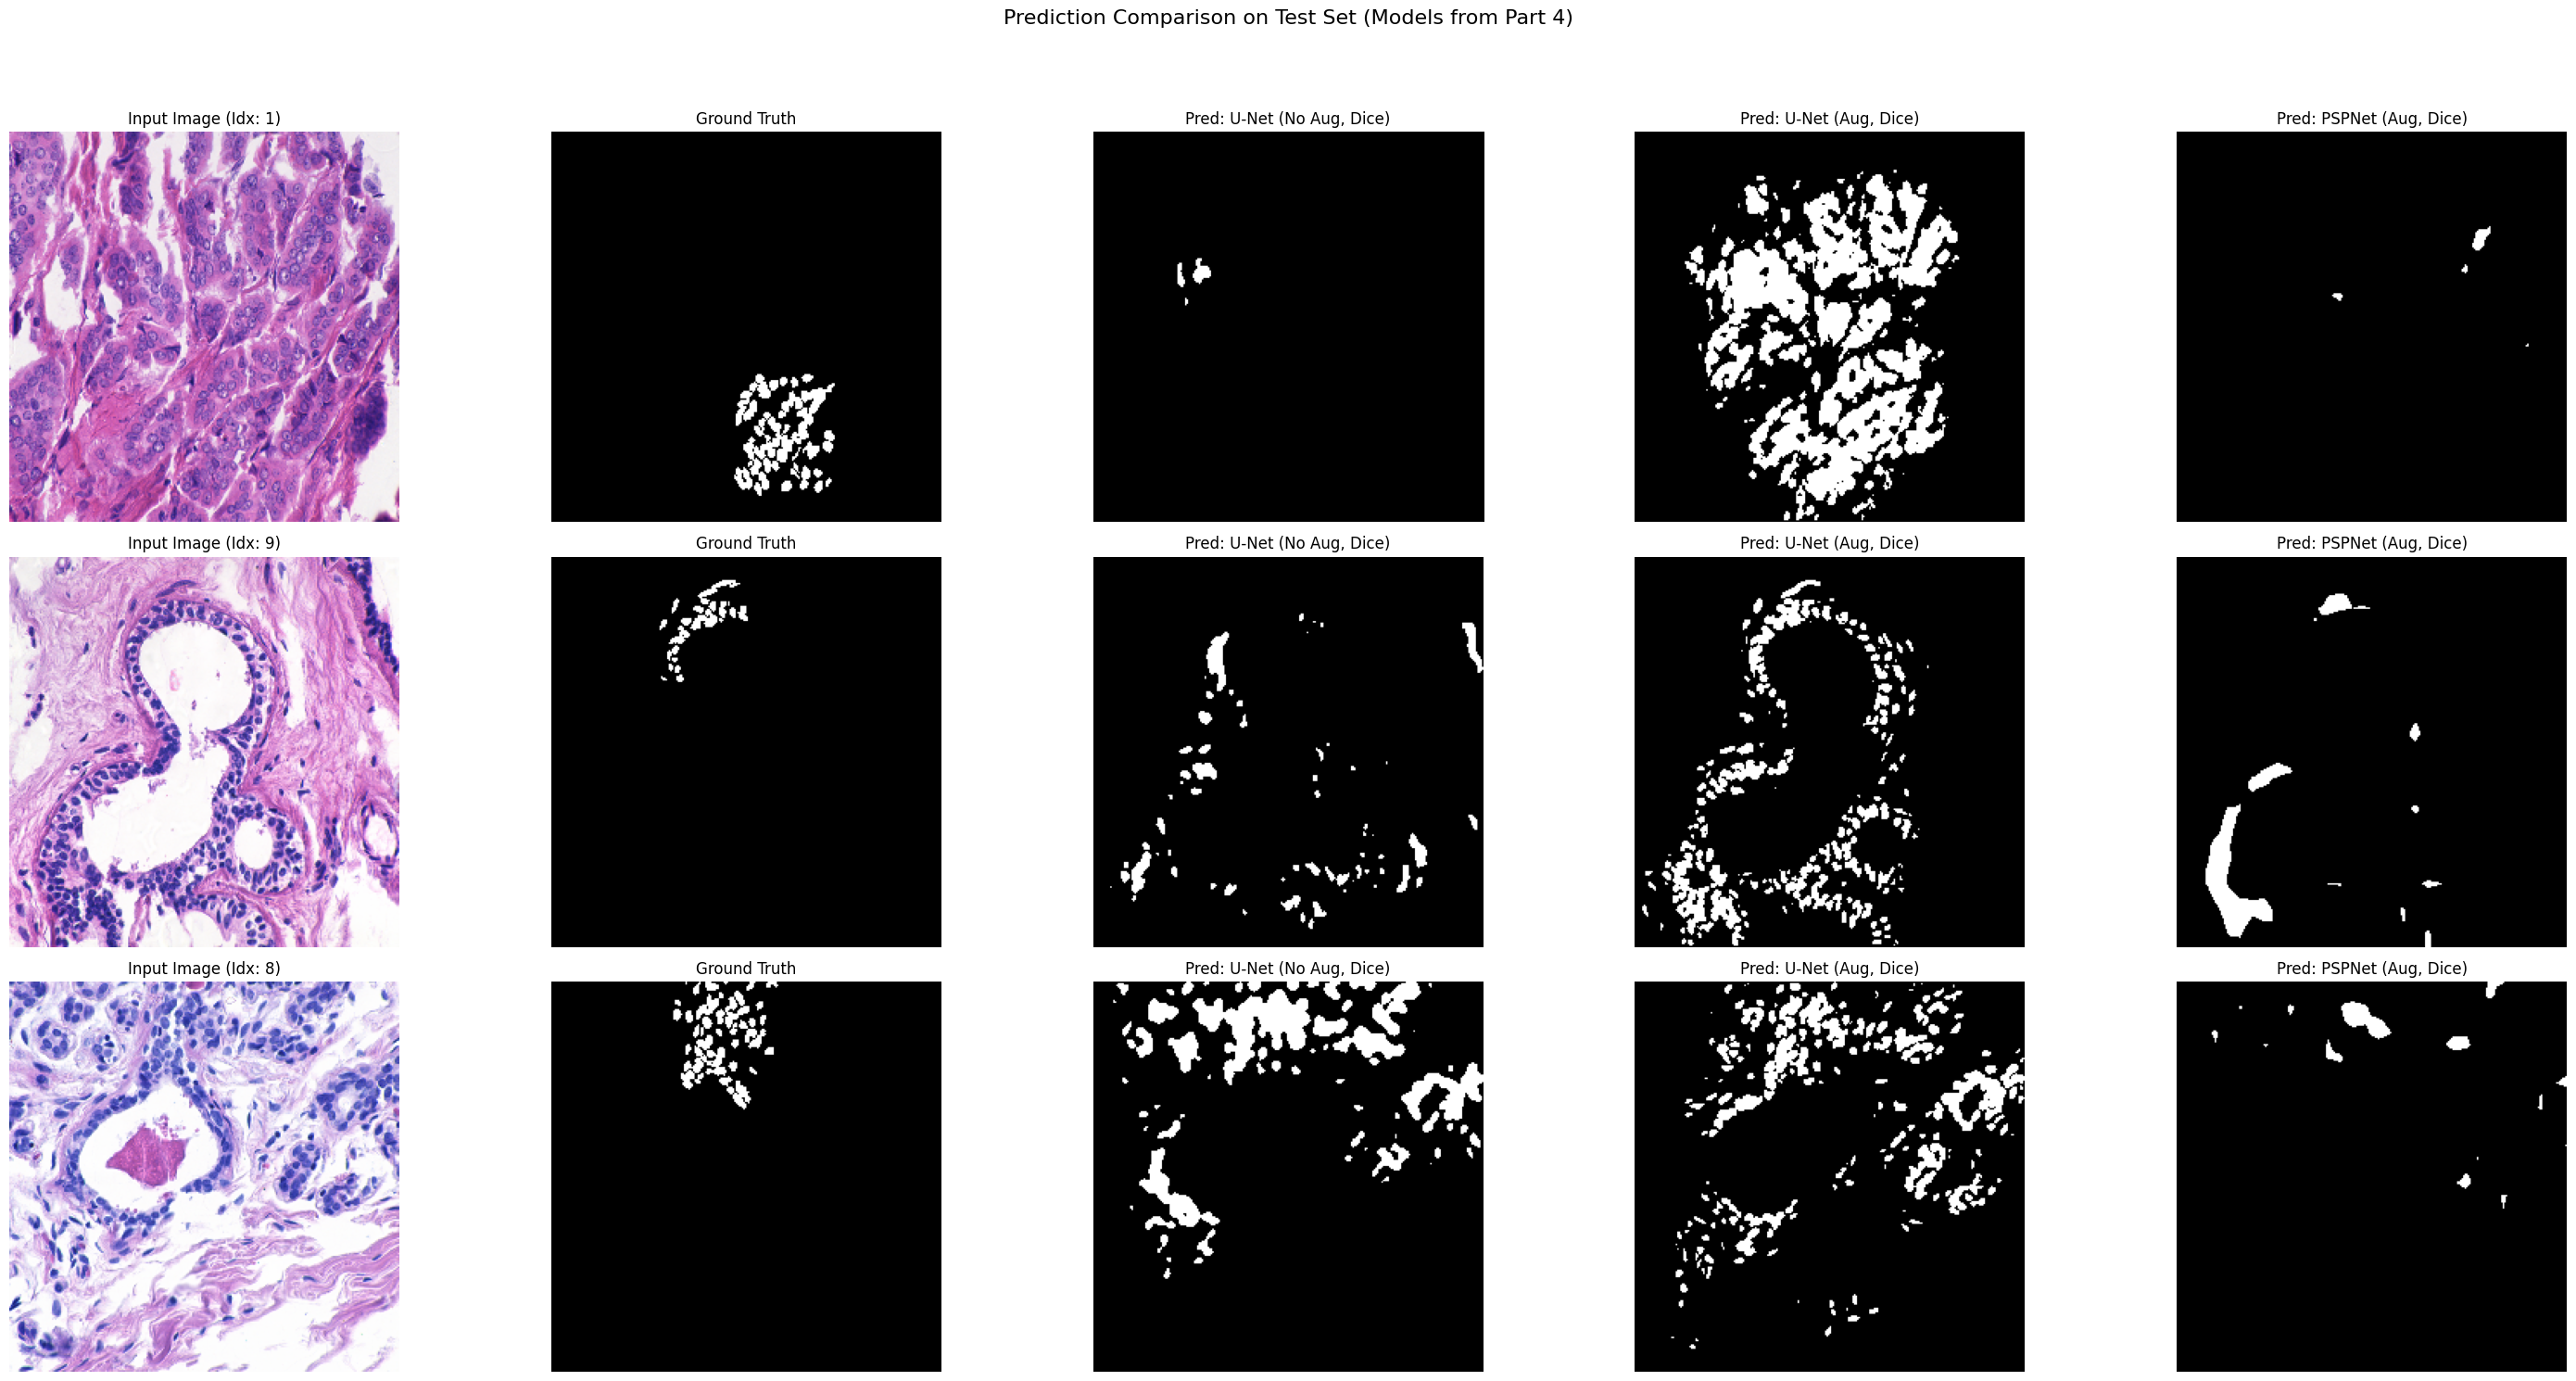

In [60]:
# --- Visualize Predictions Comparison (Optional but Recommended) ---
# Use the plotting function defined in 4.1 ('plot_predictions_part4' or similar)
# Ensure test_dataset is available

if loaded_models_final and 'test_dataset' in locals() and len(test_dataset) > 0:
    print("\n--- Visualizing Final Model Predictions ---")
    num_viz_samples = min(3, len(test_dataset))
    # Use the same indices for fair comparison if possible, or new random ones
    plot_indices_final = np.random.choice(len(test_dataset), num_viz_samples, replace=False).tolist()
    print(f"Visualizing final comparison for indices: {plot_indices_final}")
    # Assuming plot_predictions_part4 takes dict, dataset, indices, device, num_samples
    plot_predictions_part4(loaded_models_final, test_dataset, plot_indices_final, device, num_samples=num_viz_samples)
else:
    print("\nSkipping final prediction visualization (models not loaded or test_dataset missing).")


In [61]:
# --- Conclusion Text ---
print("\n--- Итоги и Выводы (Part 4.2) ---")

print("Сравнение производительности моделей на тестовом наборе:")
if 'results_df_final' in locals():
    print(results_df_final.to_string(float_format="%.4f"))
else:
    print("Результаты тестирования отсутствуют.")

print("\nАнализ:")
print("1. Влияние Аугментаций (U-Net No Aug vs U-Net Aug):")
unet_no_aug_key = f"U-Net (No Aug, {best_loss_name})"
unet_aug_key = f"U-Net (Aug, {best_loss_name})"
if 'results_df_final' in locals() and unet_no_aug_key in results_df_final.index and unet_aug_key in results_df_final.index:
    dice_no_aug = results_df_final.loc[unet_no_aug_key, 'Test Dice']
    dice_aug = results_df_final.loc[unet_aug_key, 'Test Dice']
    print(f" - U-Net без аугментаций достиг Test Dice = {dice_no_aug:.4f}.")
    print(f" - U-Net с аугментациями достиг Test Dice = {dice_aug:.4f}.")
    if dice_aug > dice_no_aug:
        print(f" - Наблюдается улучшение ({dice_aug - dice_no_aug:+.4f}) при использовании аугментаций. Это ожидаемо, так как аугментации увеличивают разнообразие обучающих данных, помогая модели лучше обобщаться и снижая риск переобучения на небольшом датасете.")
    else:
        print(" - Аугментации не привели к улучшению или даже ухудшили результат U-Net. Возможно, выбранные аугментации были слишком агрессивными или требовалось больше эпох для адаптации.")
else:
    print(" - Не удалось сравнить U-Net с аугментациями и без из-за отсутствия результатов.")

print("\n2. Влияние Архитектуры (U-Net Aug vs PSPNet Aug):")
pspnet_aug_key = f"PSPNet (Aug, {best_loss_name})"
if 'results_df_final' in locals() and unet_aug_key in results_df_final.index and pspnet_aug_key in results_df_final.index:
    dice_unet_aug = results_df_final.loc[unet_aug_key, 'Test Dice']
    dice_pspnet_aug = results_df_final.loc[pspnet_aug_key, 'Test Dice']
    print(f" - U-Net с аугментациями достиг Test Dice = {dice_unet_aug:.4f}.")
    print(f" - PSPNet с аугментациями достиг Test Dice = {dice_pspnet_aug:.4f}.")
    if dice_pspnet_aug > dice_unet_aug:
         print(f" - PSPNet показал лучший результат ({dice_pspnet_aug - dice_unet_aug:+.4f}). Его архитектура с Pyramid Pooling Module позволяет агрегировать контекст на разных масштабах, что может быть полезно для объектов разного размера, как клетки.")
    elif dice_pspnet_aug == dice_unet_aug :
         print(f" - PSPNet показал такой же результат как и U-Net Aug. Возможно для этой задачи и выбранного энкодера (resnet34) более сложная архитектура не дает преимуществ.")
    else:
         print(f" - PSPNet показал худший результат ({dice_pspnet_aug - dice_unet_aug:+.4f}). Возможно, более сложная модель требует больше данных, больше эпох обучения или более тонкой настройки гиперпараметров (например, learning rate для энкодера и декодера).")

elif SMP_AVAILABLE:
     print(" - Не удалось сравнить U-Net (Aug) и PSPNet (Aug) из-за отсутствия результатов одной из моделей.")
else:
     print(" - PSPNet не обучался из-за отсутствия библиотеки segmentation-models-pytorch.")


print("\nОбщий вывод:")
if 'best_model_final_name' in locals():
    print(f" - Лучшей конфигурацией по метрике Test Dice является: '{best_model_final_name}'.")
    # Ссылка на рассчитанное улучшение
    if baseline_model_name in results_df_final.index:
         dice_improvement = best_final_metrics['Test Dice'] - baseline_metrics['Test Dice']
         print(f" - Это обеспечило улучшение Dice на {dice_improvement:+.4f} по сравнению с базовой моделью U-Net без аугментаций.")
    elif 'test_results_best_model' in locals() and test_results_best_model: # Проверка на загруженные результаты из 3.1
         baseline_dice = test_results_best_model.get('test_dice', float('nan'))
         if not np.isnan(baseline_dice):
            dice_improvement = best_final_metrics['Test Dice'] - baseline_dice
            print(f" - Это обеспечило улучшение Dice на {dice_improvement:+.4f} по сравнению с базовой моделью U-Net без аугментаций (результат из Part 3.1).")

    print(" - Визуальный анализ предсказаний лучшей модели на тестовых данных подтверждает (или не подтверждает - смотреть глазами!) её способность корректно сегментировать клетки.")
    print(" - Использование аугментаций данных является ключевым фактором для улучшения качества сегментации на данном датасете.")
    if "PSPNet" in best_model_final_name:
        print(" - Переход к более сложной архитектуре (PSPNet) также внес положительный вклад (или нет - см. п.2 анализа).")
    else:
        print(" - В данном эксперименте простая U-Net с аугментациями оказалась достаточной или даже превзошла PSPNet.")

else:
    print(" - Не удалось определить лучшую модель из-за отсутствия полных результатов тестирования.")

print("\nОграничения и Возможные Улучшения:")
print(" - Размер датасета мал, результаты могут сильно зависеть от разделения данных.")
print(" - Гиперпараметры (learning rate, batch size, параметры аугментаций) не оптимизировались.")
print(" - Можно попробовать другие архитектуры (DeepLabV3+, MA-Net) или другие бэкбоны для PSPNet/U-Net (ResNet50, EfficientNet).")
print(" - Пост-обработка предсказаний (удаление мелких объектов, заполнение дыр) может улучшить метрики.")


--- Итоги и Выводы (Part 4.2) ---
Сравнение производительности моделей на тестовом наборе:
                      Test Loss  Test Dice  Test IoU
PSPNet (Aug, Dice)       0.8282     0.1539    0.1102
U-Net (Aug, Dice)        0.8670     0.1366    0.1161
U-Net (No Aug, Dice)     0.9371     0.0632    0.0785

Анализ:
1. Влияние Аугментаций (U-Net No Aug vs U-Net Aug):
 - U-Net без аугментаций достиг Test Dice = 0.0632.
 - U-Net с аугментациями достиг Test Dice = 0.1366.
 - Наблюдается улучшение (+0.0734) при использовании аугментаций. Это ожидаемо, так как аугментации увеличивают разнообразие обучающих данных, помогая модели лучше обобщаться и снижая риск переобучения на небольшом датасете.

2. Влияние Архитектуры (U-Net Aug vs PSPNet Aug):
 - U-Net с аугментациями достиг Test Dice = 0.1366.
 - PSPNet с аугментациями достиг Test Dice = 0.1539.
 - PSPNet показал лучший результат (+0.0173). Его архитектура с Pyramid Pooling Module позволяет агрегировать контекст на разных масштабах, что может 

In [62]:
# --- Clean up ---
if 'loaded_models_final' in locals():
    del loaded_models_final
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()